# Notebook 08: Full Rotation-Curve Gallery

**Objective:** Show the fitted rotation curves for all 171 quality-controlled SPARC
galaxies, comparing three interpretations side-by-side:

| Curve | Color | Description |
|-------|-------|-------------|
| $V_{\text{bary}}$ | blue | Pure baryonic (gas + disk + bulge) — no dark matter or $\omega$ |
| Flynn (2025) Linear | red dashed | $V_{\text{bary}} + \omega R$ — one free parameter |
| Schneider (2026) Tapered | orange solid | $V_{\text{bary}} + \omega R / (1 + R/R_t)$ — two free parameters |

Each page contains a **2 × 3 grid** of galaxies, sorted by $\Delta$BIC (strongest
Tapered preference first).  Each panel shows:
- The rotation curve with error bars
- All three model curves
- Key fit statistics in the subtitle ($\Delta$BIC, RMSE for each model)

## Output
- `results/figures/gallery_page_{N:02d}.png` — one PNG per page of 6 galaxies
- Galaxies sorted so the most compelling Tapered wins appear first

In [15]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
from pathlib import Path

from src.physics import compute_v_bary, fit_omega, compute_bic, TaperedFitResult
from src.ingest import parse_sparc_metadata_mrt
from src.database import get_engine, get_session, query_profiles_as_dataframe
from src.utils import setup_logger, get_project_root

%matplotlib inline

UPSILON_DISK  = 0.5
UPSILON_BULGE = 0.7
METHOD_VERSION = 'v4_phase3_catalog'

PROJECT_ROOT = get_project_root()
RESULTS_DIR  = PROJECT_ROOT / 'results'
TABLES_DIR   = RESULTS_DIR / 'tables'
FIGURES_DIR  = RESULTS_DIR / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f'Project root: {PROJECT_ROOT}')

Project root: C:\Projects\ISM\baryonic-omega-analysis


## 1. Load Phase III Results & Sort by $\Delta$BIC

In [16]:
# Load the pre-computed Phase III results so we re-use exactly the same
# omega / R_t values as Notebook 07 — no re-fitting needed here.
results_df = pd.read_csv(TABLES_DIR / 'phase_iii_full_results.csv')

# Keep only quality-controlled galaxies where both fits converged
gallery_df = results_df[
    (results_df['Fit_Flag'] == 'OK') &
    results_df['Tapered_converged'].fillna(False) &
    results_df['Linear_converged'].fillna(False)
].copy()

# Sort: strongest Tapered preference first, then ambiguous, then Linear
gallery_df = gallery_df.sort_values('Delta_BIC', ascending=False).reset_index(drop=True)

print(f'Gallery: {len(gallery_df)} galaxies')
print(f'Delta_BIC range: [{gallery_df["Delta_BIC"].min():.1f}, {gallery_df["Delta_BIC"].max():.1f}]')
gallery_df[['GalaxyID','Delta_BIC','Preferred_Model','Linear_RMSE','Tapered_RMSE']].head(10)

Gallery: 171 galaxies
Delta_BIC range: [-53.5, 19023.8]


GalaxyID     Delta_BIC Preferred_Model  Linear_RMSE  Tapered_RMSE
0  UGC02953  19023.775462         Tapered    41.706512     21.902089
1   NGC2403  16435.169649         Tapered    18.574836      5.425678
2  UGC00128  12763.397137         Tapered    35.111712      6.376166
3  UGC09133   8395.353240         Tapered    32.673018     17.658819
4  UGC06787   5474.696377         Tapered    23.456351     18.651687
5   NGC6015   4779.117337         Tapered    26.250964     11.038340
6   NGC3198   4689.301410         Tapered    22.335921      6.442369
7  UGC05716   3517.706160         Tapered    15.026353      1.431934
8  UGC06786   2470.848150         Tapered    30.192889     10.449394
9  UGC05253   2305.826176         Tapered    26.166708     16.537384

## 2. Robust Tapered Fitter (reused from Nb 07)

In [17]:
def fit_omega_tapered_robust(
    radius, v_obs, v_err, v_bary,
    galaxy_id='unknown',
    method_version=METHOD_VERSION,
    upsilon_disk=UPSILON_DISK,
    upsilon_bulge=UPSILON_BULGE,
):
    """Identical to Notebook 07 implementation — four initial guesses, best chi^2 kept."""
    radius  = np.asarray(radius,  dtype=np.float64)
    v_obs   = np.asarray(v_obs,   dtype=np.float64)
    v_err   = np.asarray(v_err,   dtype=np.float64)
    v_bary  = np.asarray(v_bary,  dtype=np.float64)

    n_points      = len(radius)
    positive_errs = v_err[v_err > 0]
    min_err       = float(np.min(positive_errs)) if len(positive_errs) > 0 else 1.0
    v_err_safe    = np.where(v_err > 0, v_err, min_err)
    flag_lt_bary  = bool(np.any(v_obs < v_bary))

    def _model(r, omega, r_t):
        return v_bary + omega * r / (1.0 + r / r_t)

    r_max        = radius.max()
    omega_bounds = (0.0,  200.0)
    rt_bounds    = (0.1,  r_max * 5.0)

    initial_guesses = [
        [5.0,  r_max * 0.3],
        [10.0, r_max * 0.1],
        [3.0,  r_max * 1.0],
        [20.0, r_max * 2.0],
    ]

    best_result = None
    best_chi2   = np.inf

    for p0 in initial_guesses:
        p0c = [
            np.clip(p0[0], omega_bounds[0] + 1e-4, omega_bounds[1] - 1e-4),
            np.clip(p0[1], rt_bounds[0]    + 1e-4, rt_bounds[1]    - 1e-4),
        ]
        try:
            popt, pcov = curve_fit(
                _model, radius, v_obs,
                p0=p0c,
                sigma=v_err_safe, absolute_sigma=True,
                bounds=([omega_bounds[0], rt_bounds[0]],
                        [omega_bounds[1], rt_bounds[1]]),
                maxfev=10000,
            )
            v_try = _model(radius, *popt)
            res   = v_obs - v_try
            chi2  = float(np.sum((res / v_err_safe) ** 2))
            if chi2 < best_chi2:
                best_chi2   = chi2
                best_result = (popt, pcov, v_try, res, chi2)
        except (RuntimeError, ValueError):
            continue

    if best_result is None:
        nan    = float('nan')
        v_null = _model(radius, 0.0, 1.0)
        return TaperedFitResult(
            galaxy_id=galaxy_id, model_name='rational_taper_robust',
            omega_value=nan, omega_uncertainty=nan,
            rt_value=nan, rt_uncertainty=nan,
            chi_squared=nan, reduced_chi_squared=nan,
            residuals_rmse=nan, n_points=n_points, n_params=2,
            converged=False, flag_v_obs_lt_v_bary=flag_lt_bary,
            method_version=method_version,
            upsilon_disk=upsilon_disk, upsilon_bulge=upsilon_bulge,
            v_bary=v_bary, v_model=v_null, residuals=v_obs - v_null,
        )

    popt, pcov, v_model, residuals, chi2 = best_result
    omega_best, rt_best = float(popt[0]), float(popt[1])
    perr         = np.sqrt(np.diag(pcov))
    dof          = max(n_points - 2, 1)
    reduced_chi2 = chi2 / dof
    rmse         = float(np.sqrt(np.mean(residuals ** 2)))

    return TaperedFitResult(
        galaxy_id=galaxy_id, model_name='rational_taper_robust',
        omega_value=omega_best, omega_uncertainty=float(perr[0]),
        rt_value=rt_best,       rt_uncertainty=float(perr[1]),
        chi_squared=chi2, reduced_chi_squared=reduced_chi2,
        residuals_rmse=rmse, n_points=n_points, n_params=2,
        converged=True, flag_v_obs_lt_v_bary=flag_lt_bary,
        method_version=method_version,
        upsilon_disk=upsilon_disk, upsilon_bulge=upsilon_bulge,
        v_bary=v_bary, v_model=v_model, residuals=residuals,
    )


print('Fitter ready.')

Fitter ready.


## 3. Single-Galaxy Plot Helper

In [18]:
def plot_galaxy_panel(
    ax,
    gid,
    radius, v_obs, v_err, v_bary,
    lin_omega, lin_rmse, lin_bic,
    tap_omega, tap_rt, tap_rmse, tap_bic,
    delta_bic, preferred,
    r_disk=np.nan,
):
    """Draw one rotation-curve comparison panel onto `ax`.

    Layout (top to bottom within each panel's allocated space)
    ----------------------------------------------------------
    [title]      GalaxyID  [ΔBIC → preferred]   ← bold, BIC-coloured
    [subtitle]   ω_lin=…  ω_tap=…  |  Rₜ=…  k=…  RMSE …→…   ← two columns
    [top spine]
    [data area]                                  ← completely clear
    [bottom-right legend]  curve names only
    """
    r_plot = np.linspace(0.0, radius.max() * 1.05, 300)

    v_bary_plot = np.interp(r_plot, radius, v_bary,
                            left=v_bary[0], right=v_bary[-1])

    v_lin_plot = v_bary_plot + lin_omega * r_plot

    tap_ok = np.isfinite(tap_rt) and tap_rt > 0 and np.isfinite(tap_omega)
    v_tap_plot = (v_bary_plot + tap_omega * r_plot / (1.0 + r_plot / tap_rt)
                  if tap_ok else None)

    # --- Curves ---
    ax.errorbar(radius, v_obs, yerr=v_err,
                fmt='ko', markersize=3, capsize=2, linewidth=0.7,
                label=r'$V_{\rm obs}$', zorder=5)
    ax.plot(r_plot, v_bary_plot,
            color='steelblue', linewidth=1.5, alpha=0.65,
            label=r'$V_{\rm bary}$', zorder=3)
    ax.plot(r_plot, v_lin_plot,
            color='firebrick', linewidth=1.8, linestyle='--',
            label='Linear', zorder=4)
    if v_tap_plot is not None:
        ax.plot(r_plot, v_tap_plot,
                color='darkorange', linewidth=2.2,
                label='Tapered', zorder=4)
    if tap_ok and 0 < tap_rt < radius.max() * 1.5:
        ax.axvline(tap_rt, color='darkorange', linewidth=0.8,
                   linestyle=':', alpha=0.7)

    ax.set_xlim(left=0, right=radius.max() * 1.1)
    ax.set_ylim(bottom=0)
    ax.tick_params(labelsize=7)
    ax.set_xlabel('R (kpc)', fontsize=7)
    ax.set_ylabel('V (km/s)', fontsize=7)
    ax.grid(True, alpha=0.25)
    ax.legend(fontsize=6, loc='lower right', framealpha=0.7)

    # --- Two-column subtitle — sits between the top spine and the title ---
    # y=1.01 is just above the top spine; va='bottom' means text grows upward,
    # so it occupies the gap and does not touch the data area below.
    k_str  = (f'k={tap_rt / r_disk:.2f}'
               if (tap_ok and np.isfinite(r_disk) and r_disk > 0) else 'k=n/a')
    rt_str = (f'$R_t$={tap_rt:.2f} kpc  {k_str}' if tap_ok else '$R_t$=n/a')

    ax.text(0.01, 1.01,
            f'$\\omega_{{\\rm lin}}$={lin_omega:.2f}\n'
            f'$\\omega_{{\\rm tap}}$={tap_omega:.2f}',
            transform=ax.transAxes, ha='left', va='bottom',
            fontsize=6.5, family='monospace', color='#333333', linespacing=1.5)

    ax.text(0.52, 1.01,
            f'{rt_str}\n'
            f'RMSE {lin_rmse:.1f}\u2192{tap_rmse:.1f} km/s',
            transform=ax.transAxes, ha='left', va='bottom',
            fontsize=6.5, family='monospace', color='#333333', linespacing=1.5)

    # --- Title sits above the subtitle block ---
    # pad is in points.  Two lines at fontsize 6.5 with linespacing 1.5
    # occupy ~22 pt; add ~8 pt breathing room above the spine = 30 pt total.
    badge_color = {'Tapered': 'darkorange', 'Linear': 'firebrick'}.get(preferred, 'dimgrey')
    bic_str = (f'\u0394BIC={delta_bic:+.0f}' if abs(delta_bic) < 9999
               else '\u0394BIC\u226b0')
    ax.set_title(
        f'{gid}   [{bic_str}  \u2192  {preferred}]',
        fontsize=8.5, color=badge_color, fontweight='bold', pad=30,
    )


print('Panel helper ready.')

Panel helper ready.


## 4. The Gallery Loop

Iterates through all quality-controlled galaxies in order of descending $\Delta$BIC.
Each page is a 2 × 3 grid.  One PNG is saved per page.

171 galaxies  →  29 pages of 6


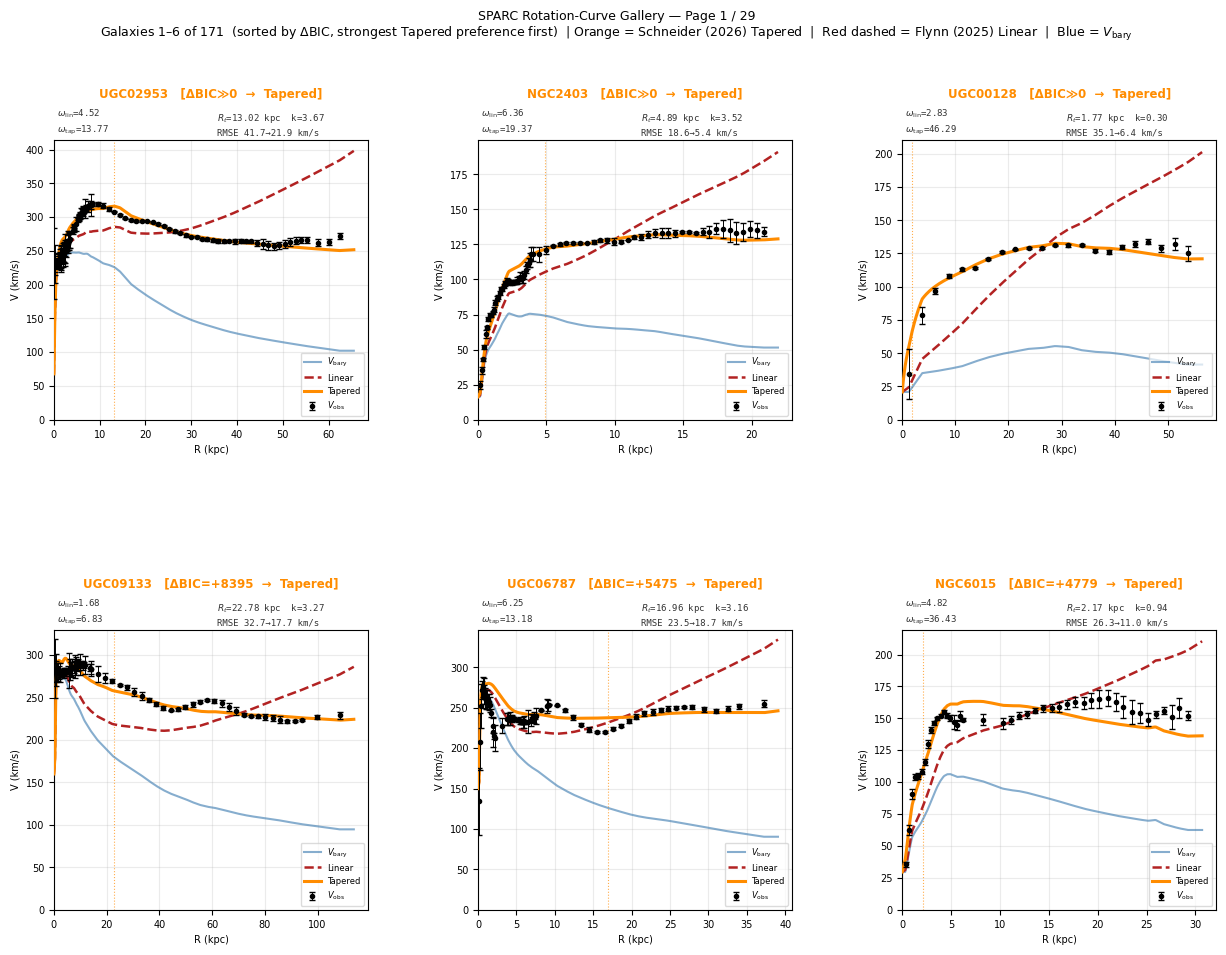

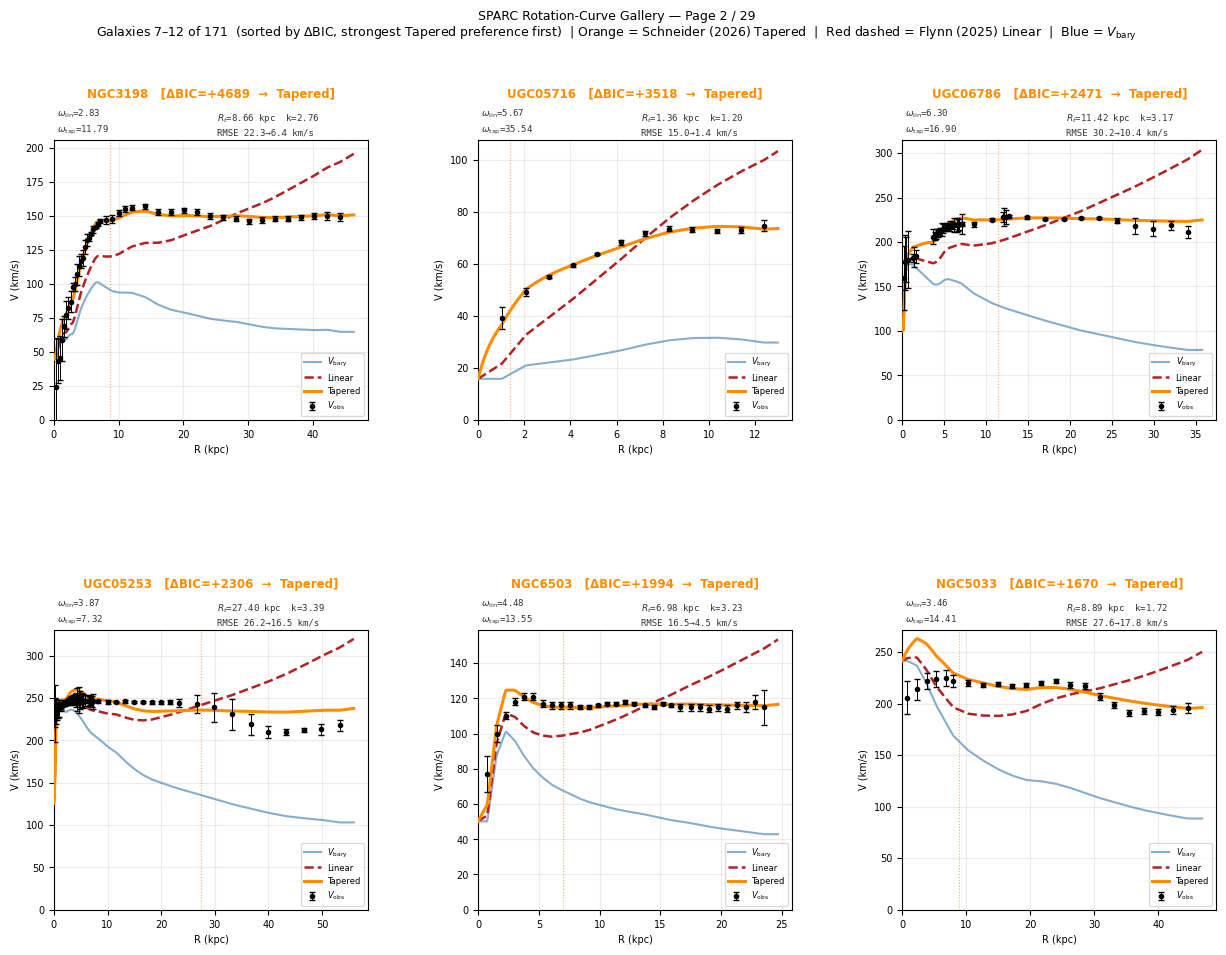

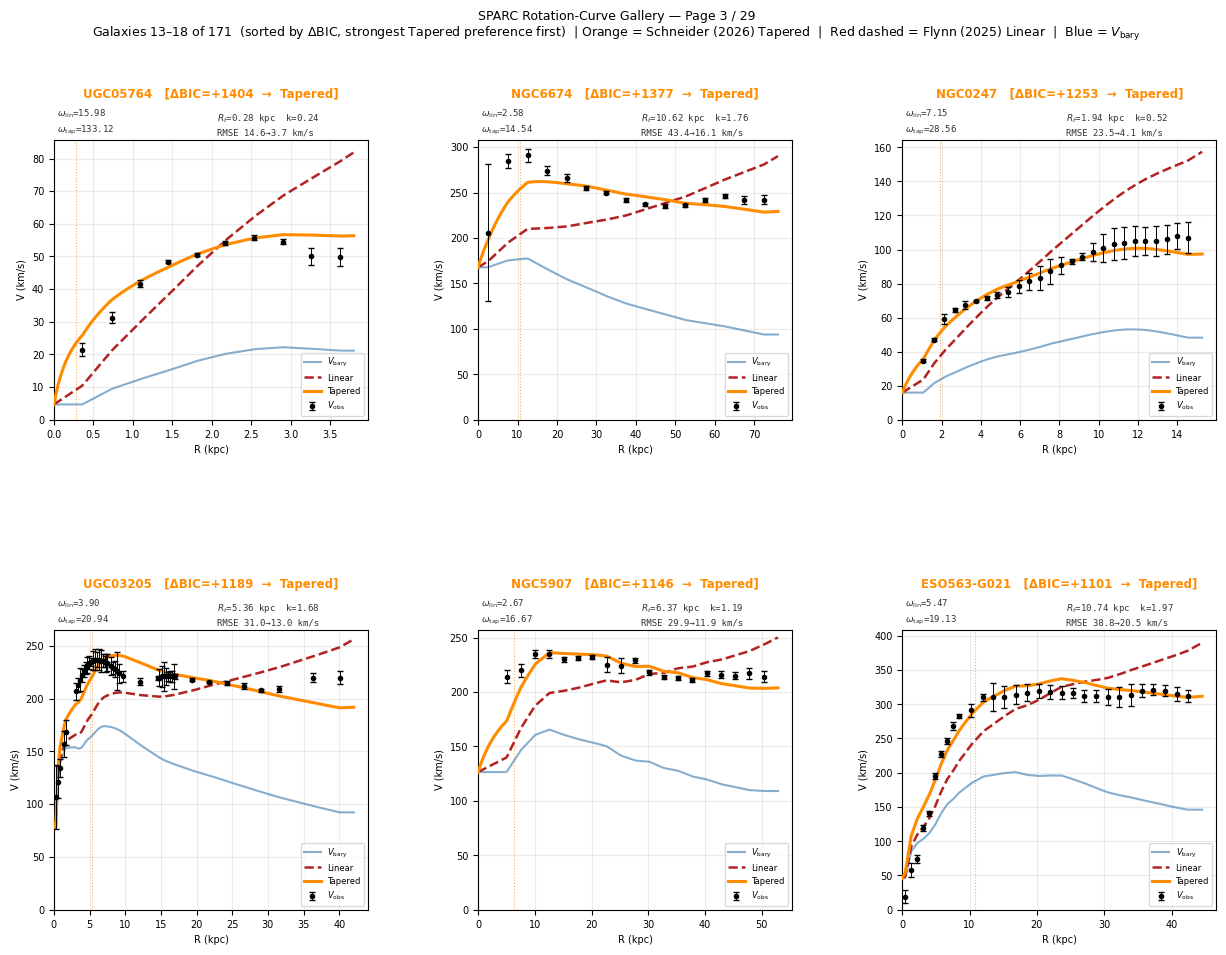

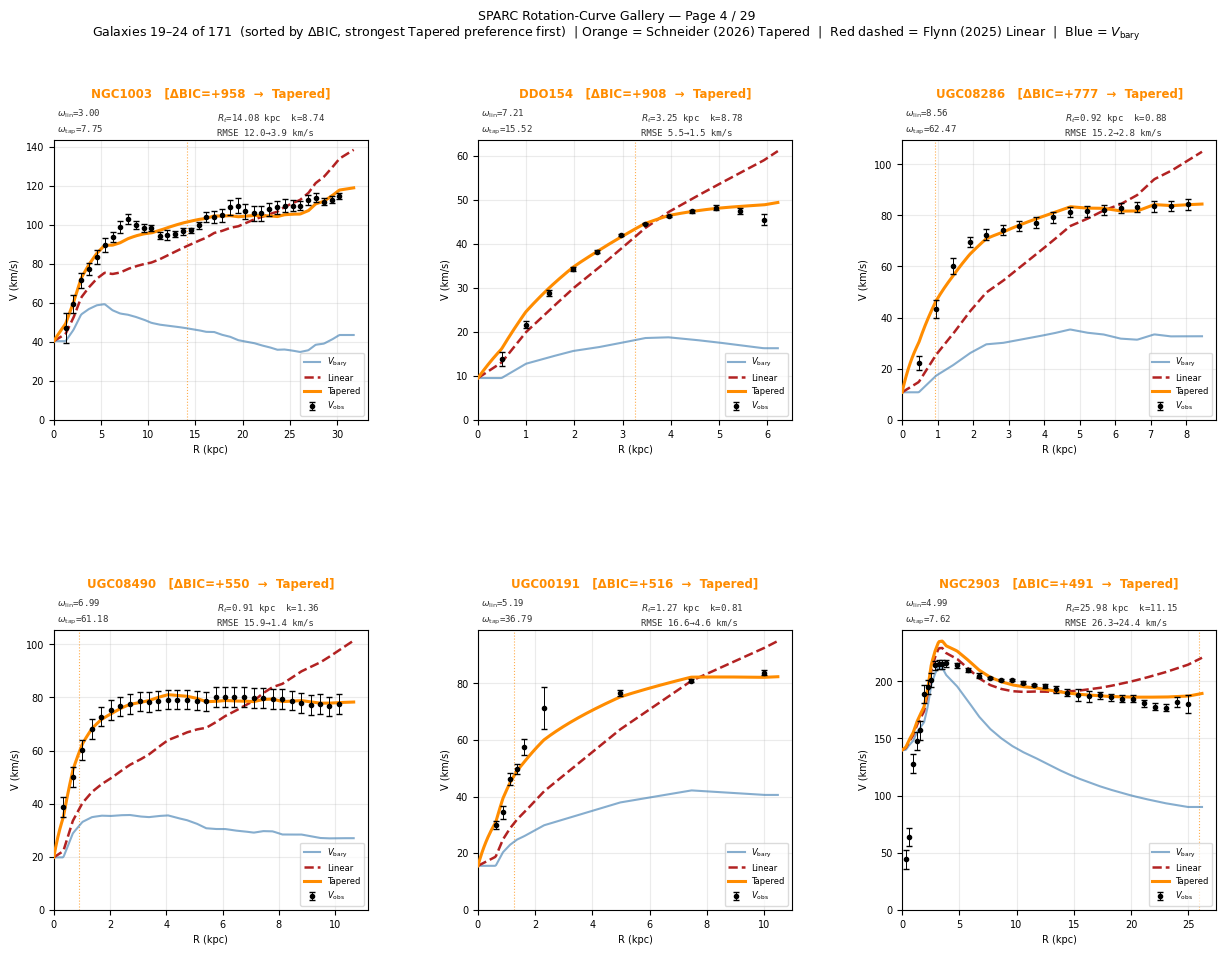

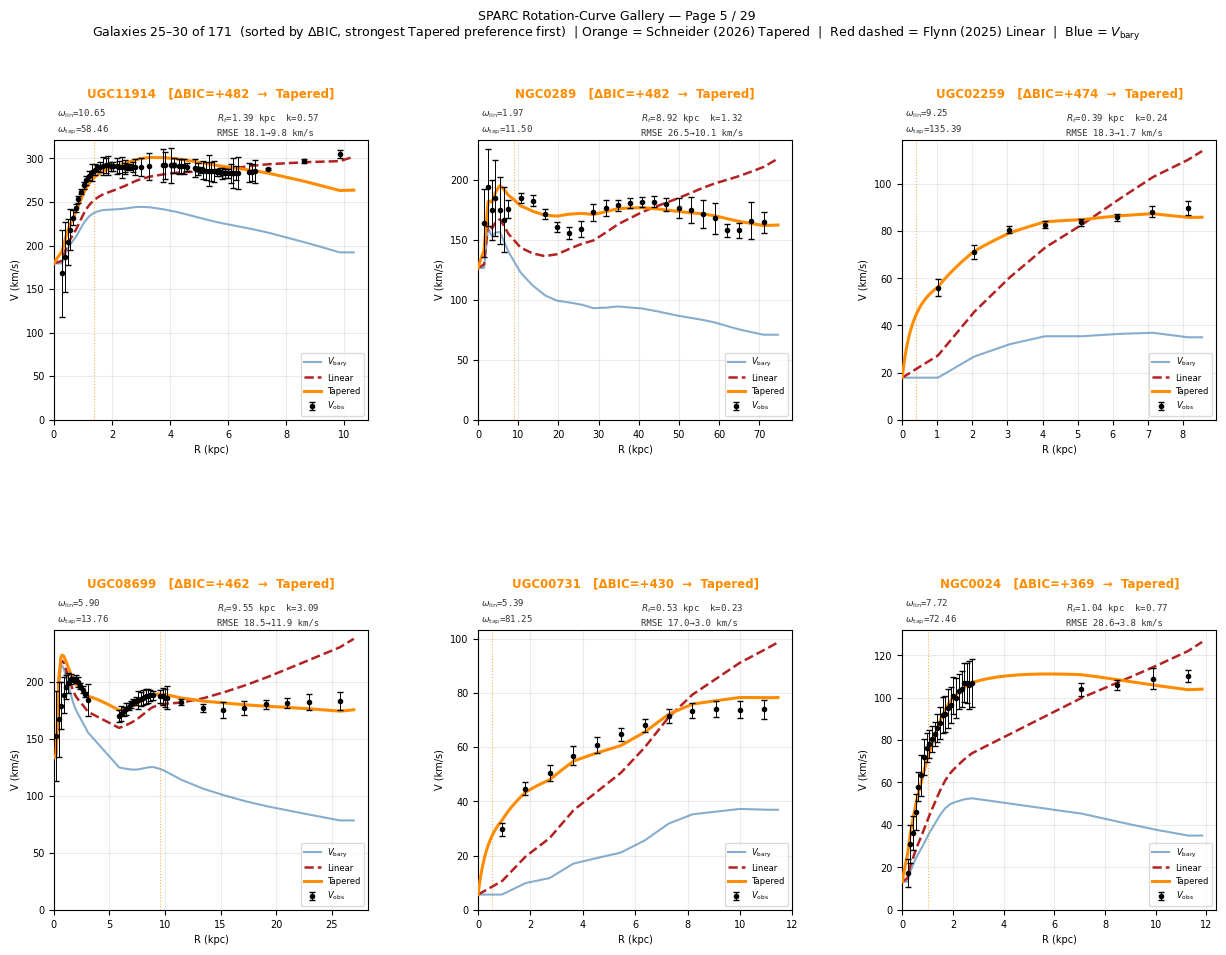

  Saved pages 1–5 ...


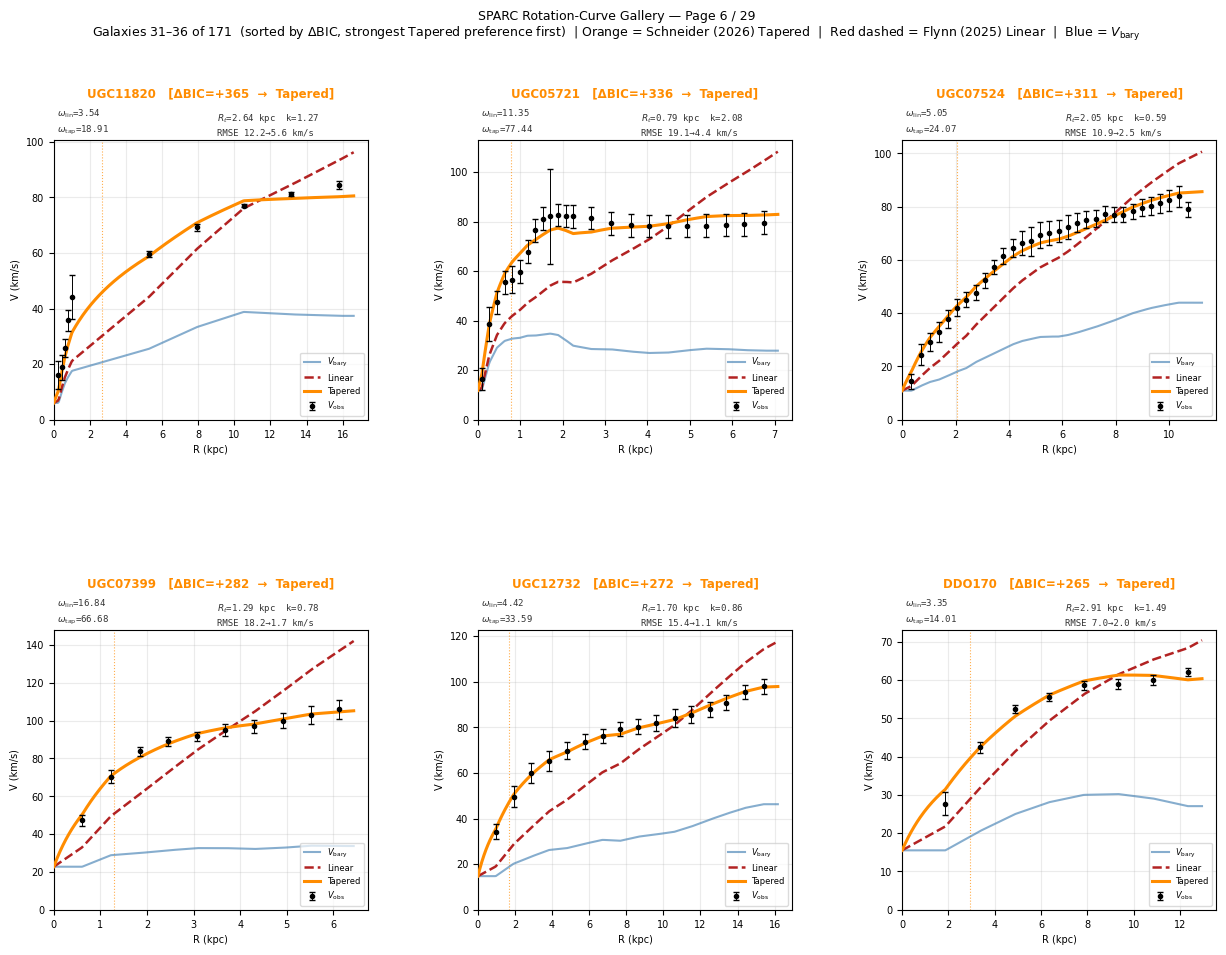

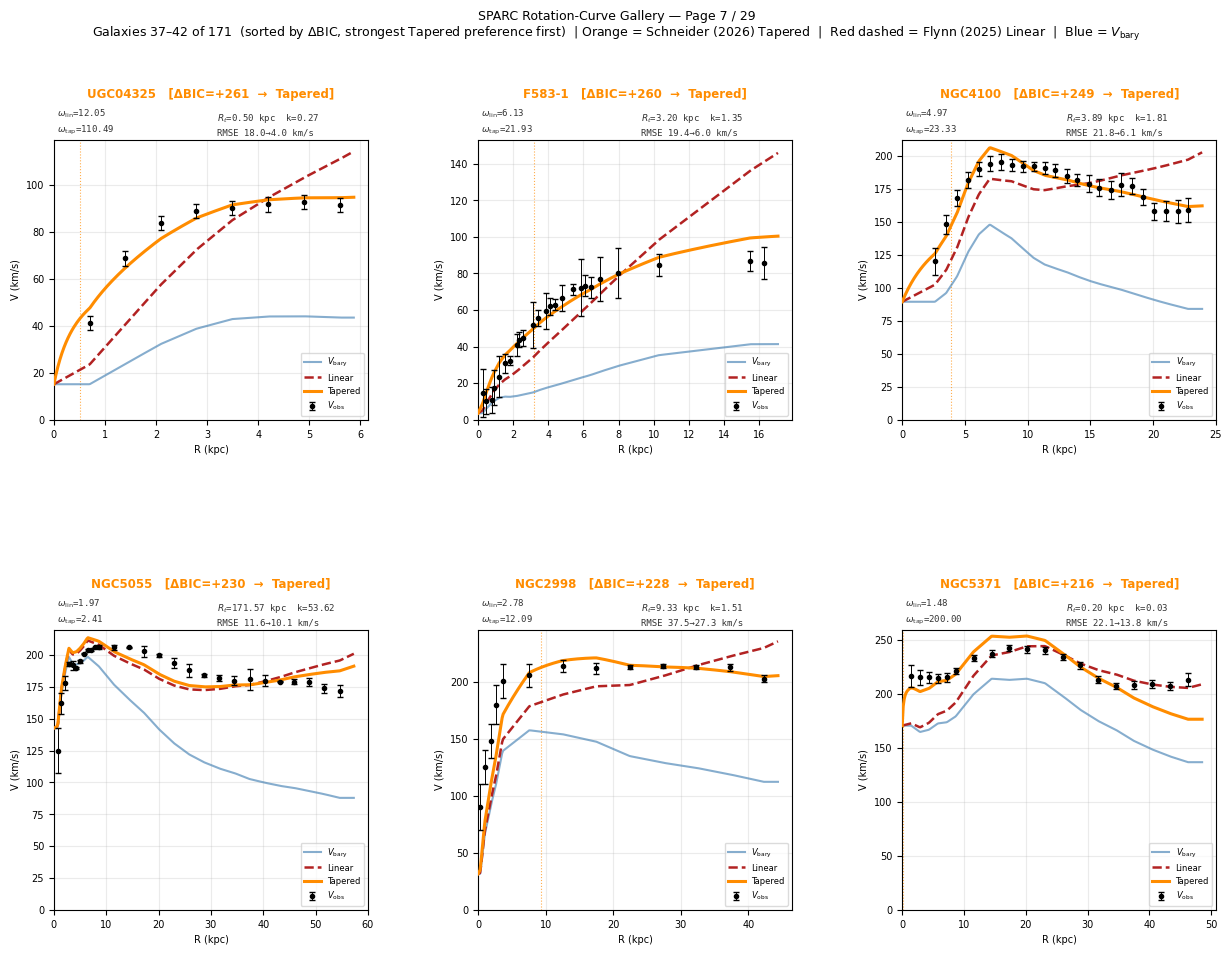

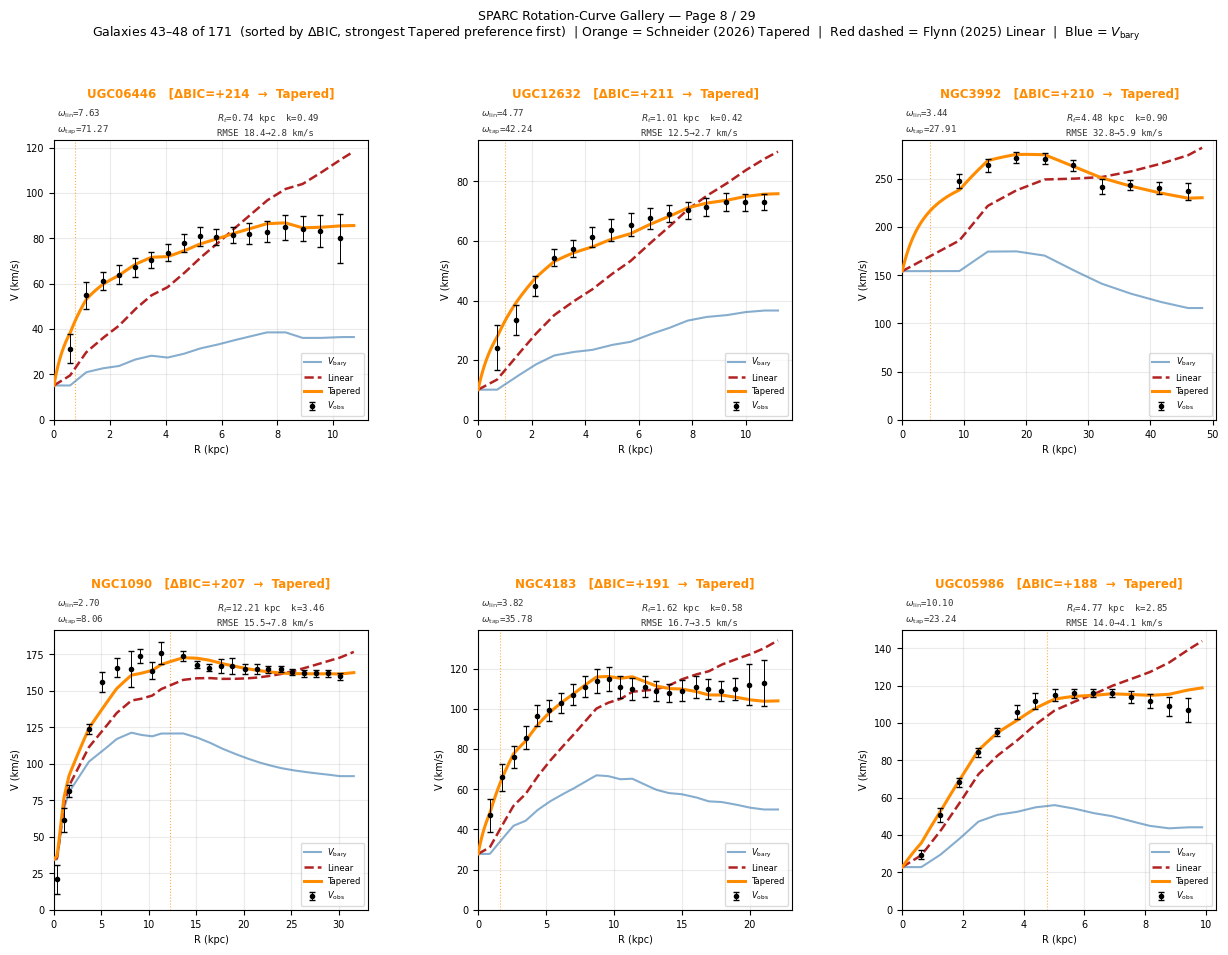

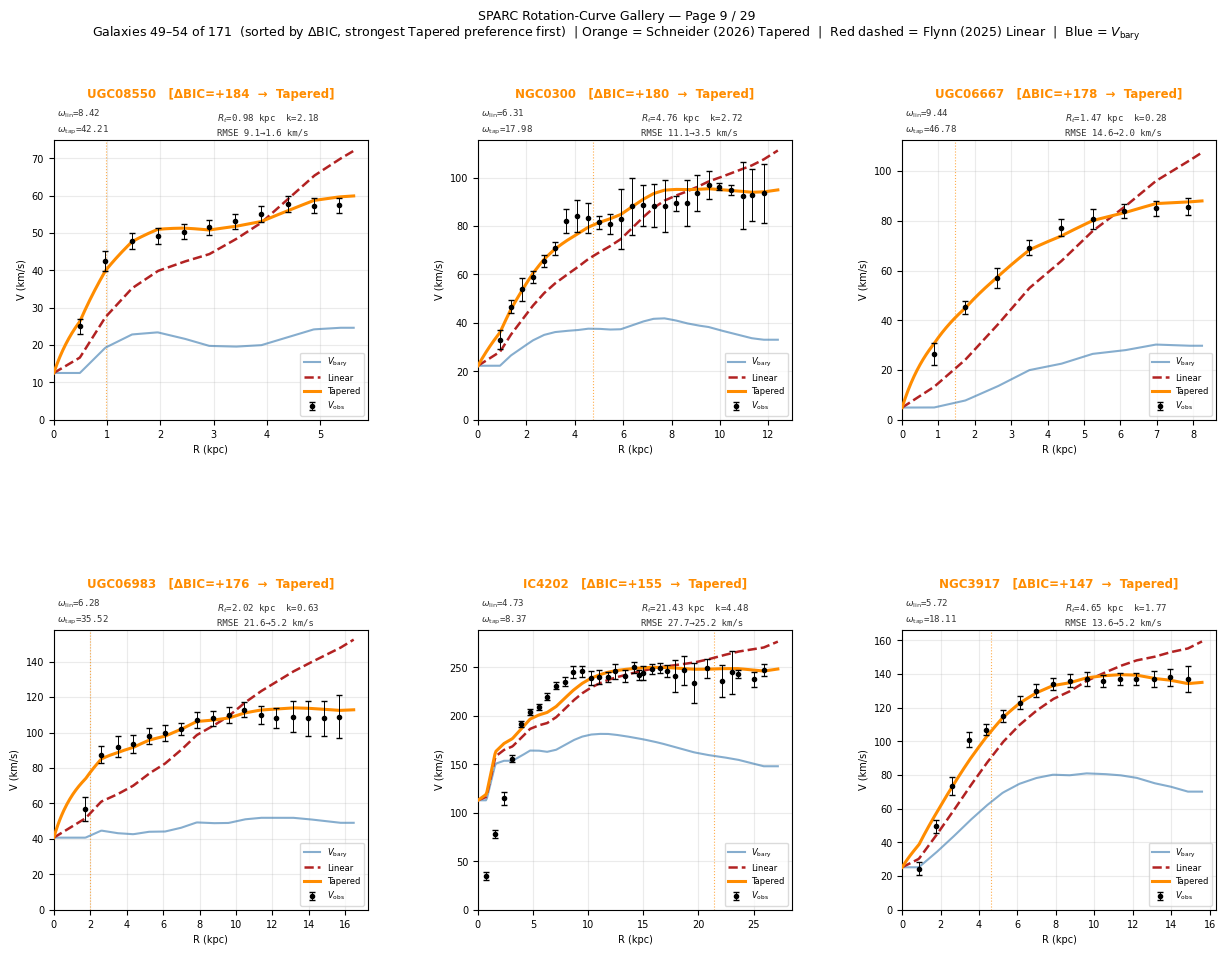

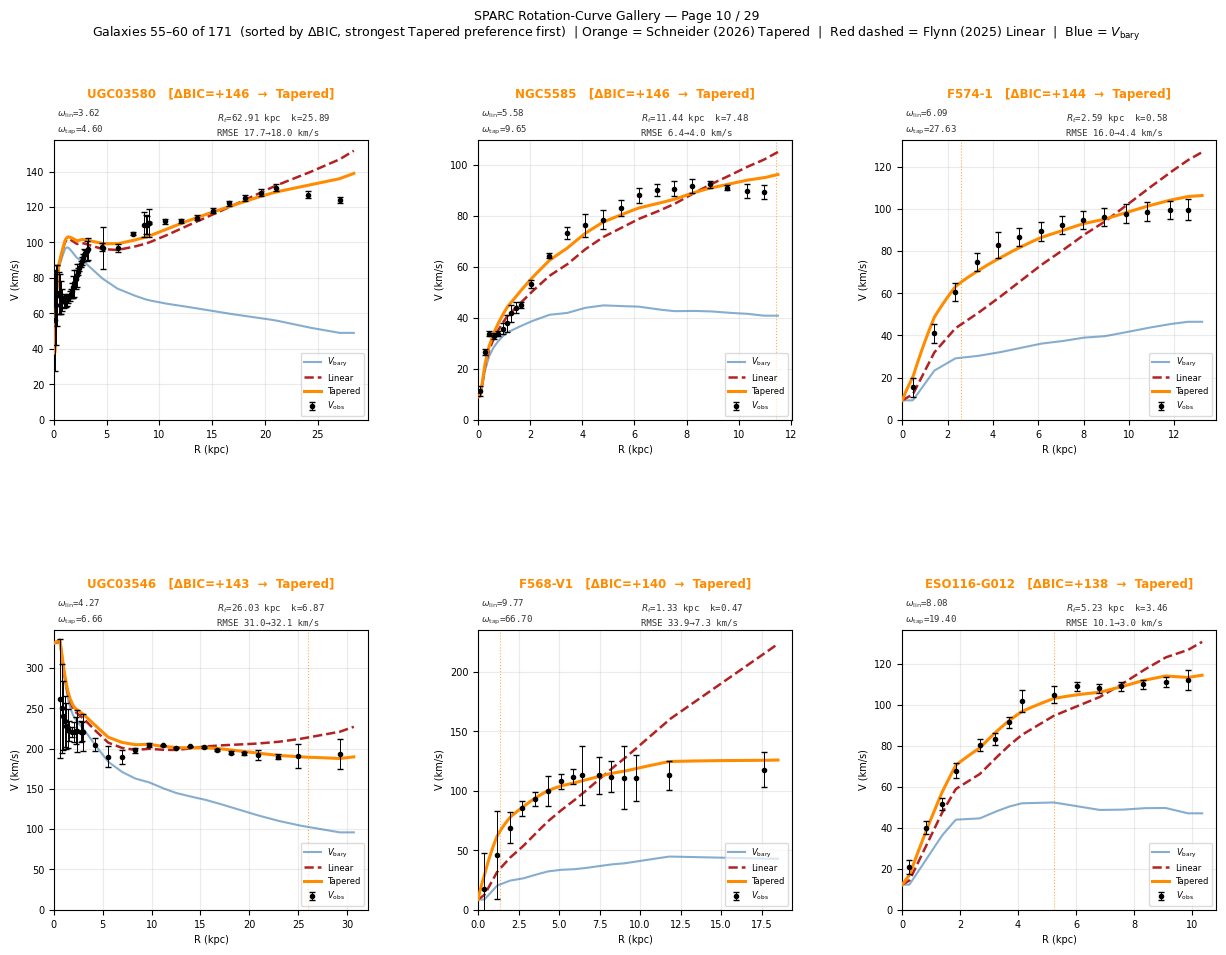

  Saved pages 1–10 ...


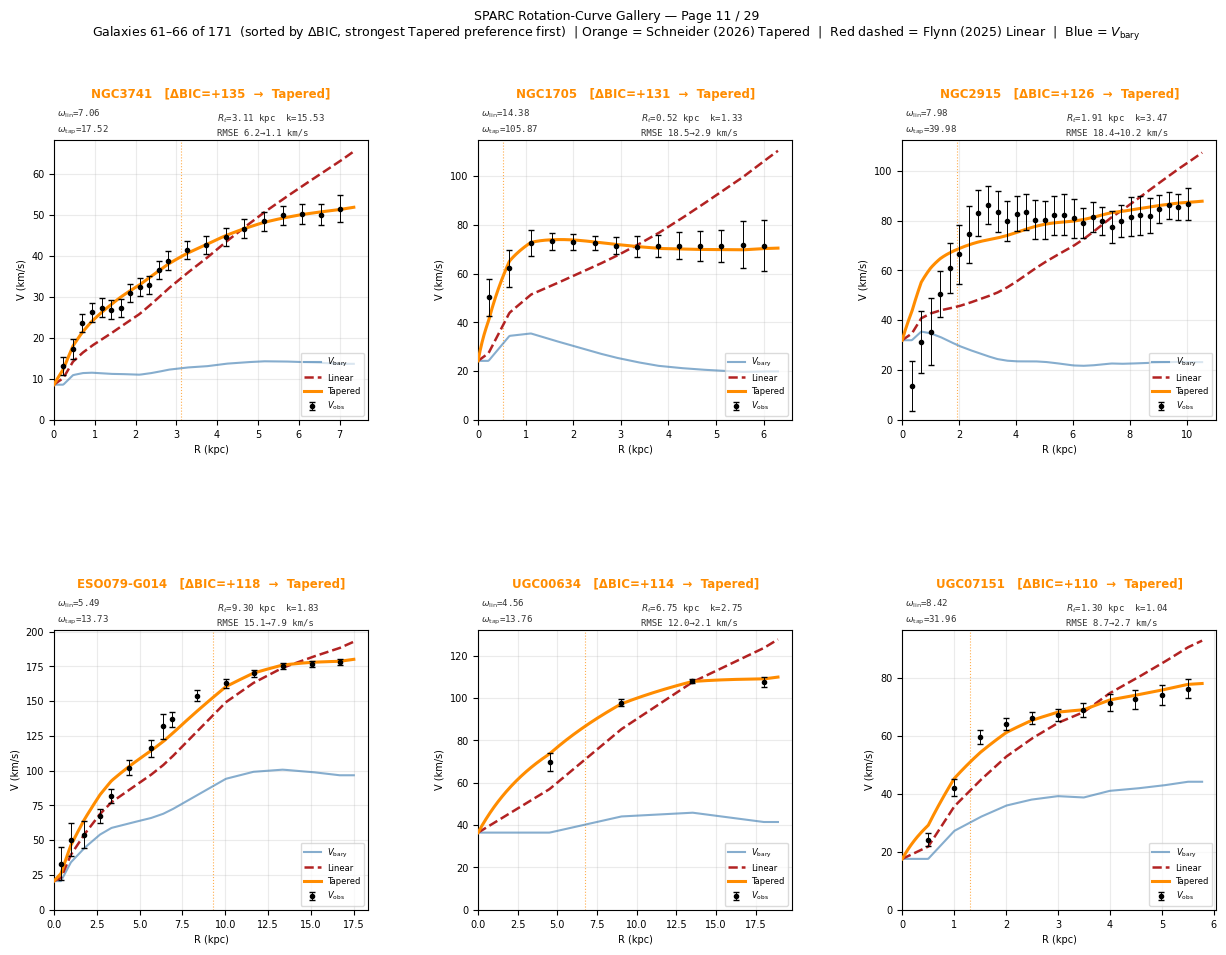

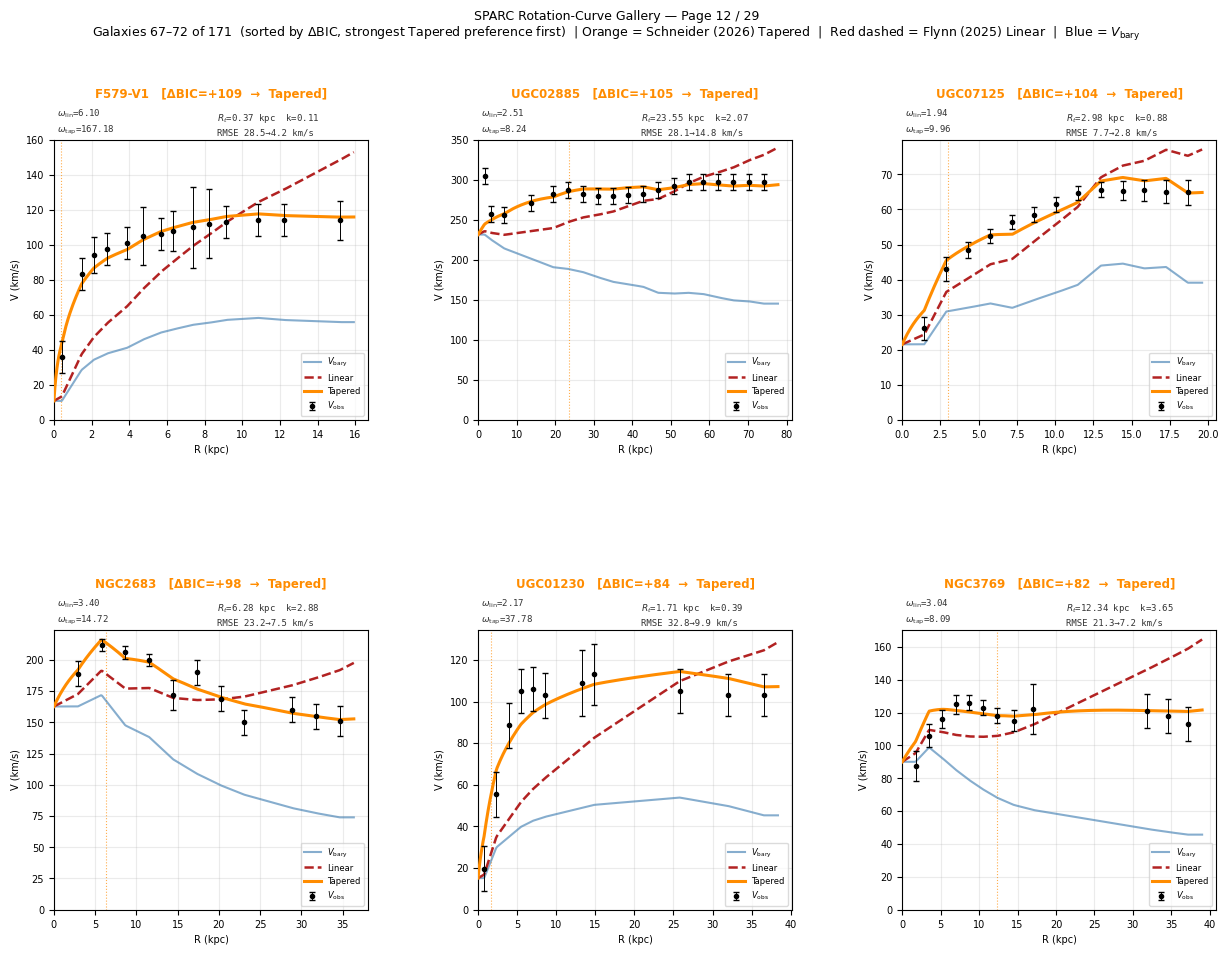

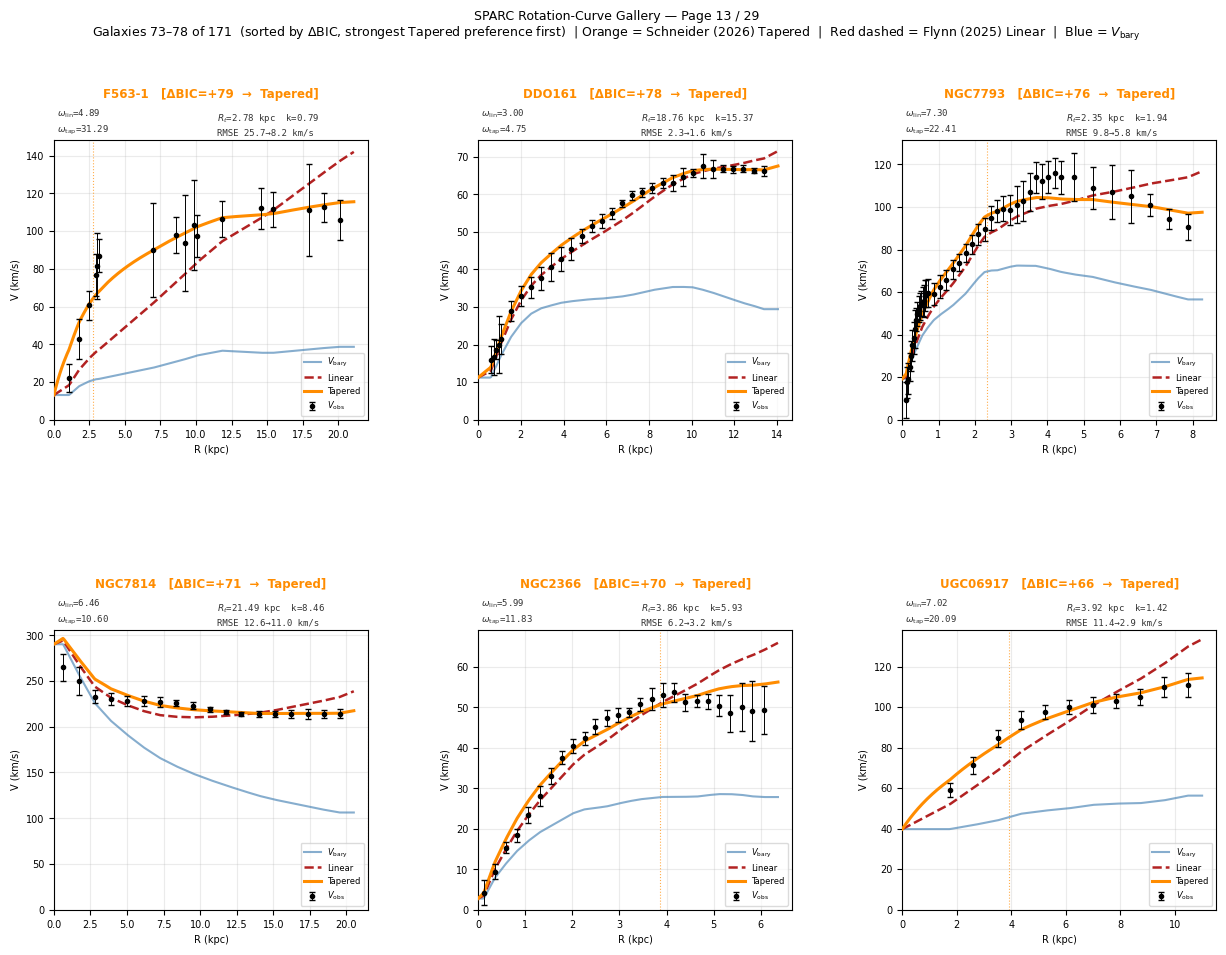

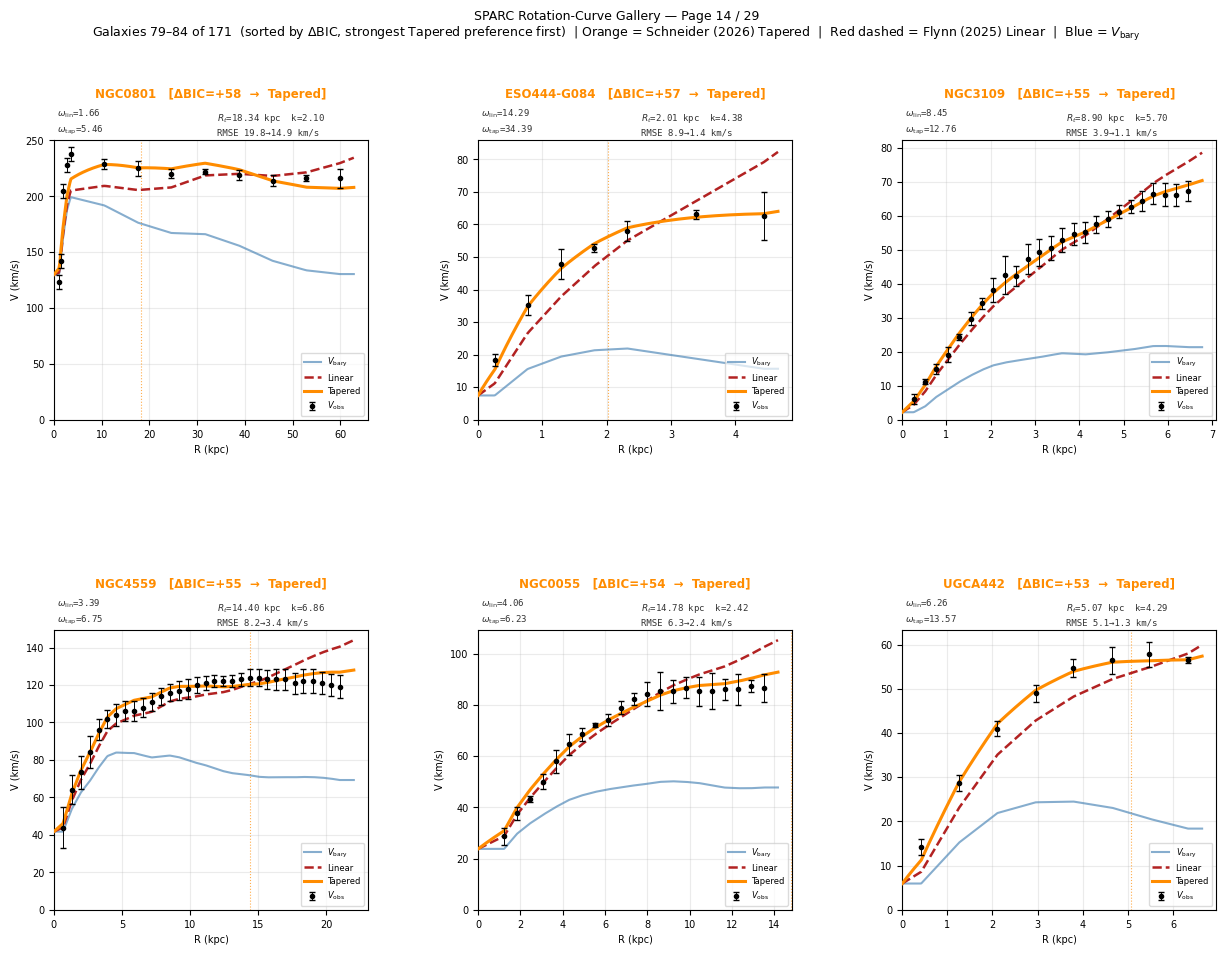

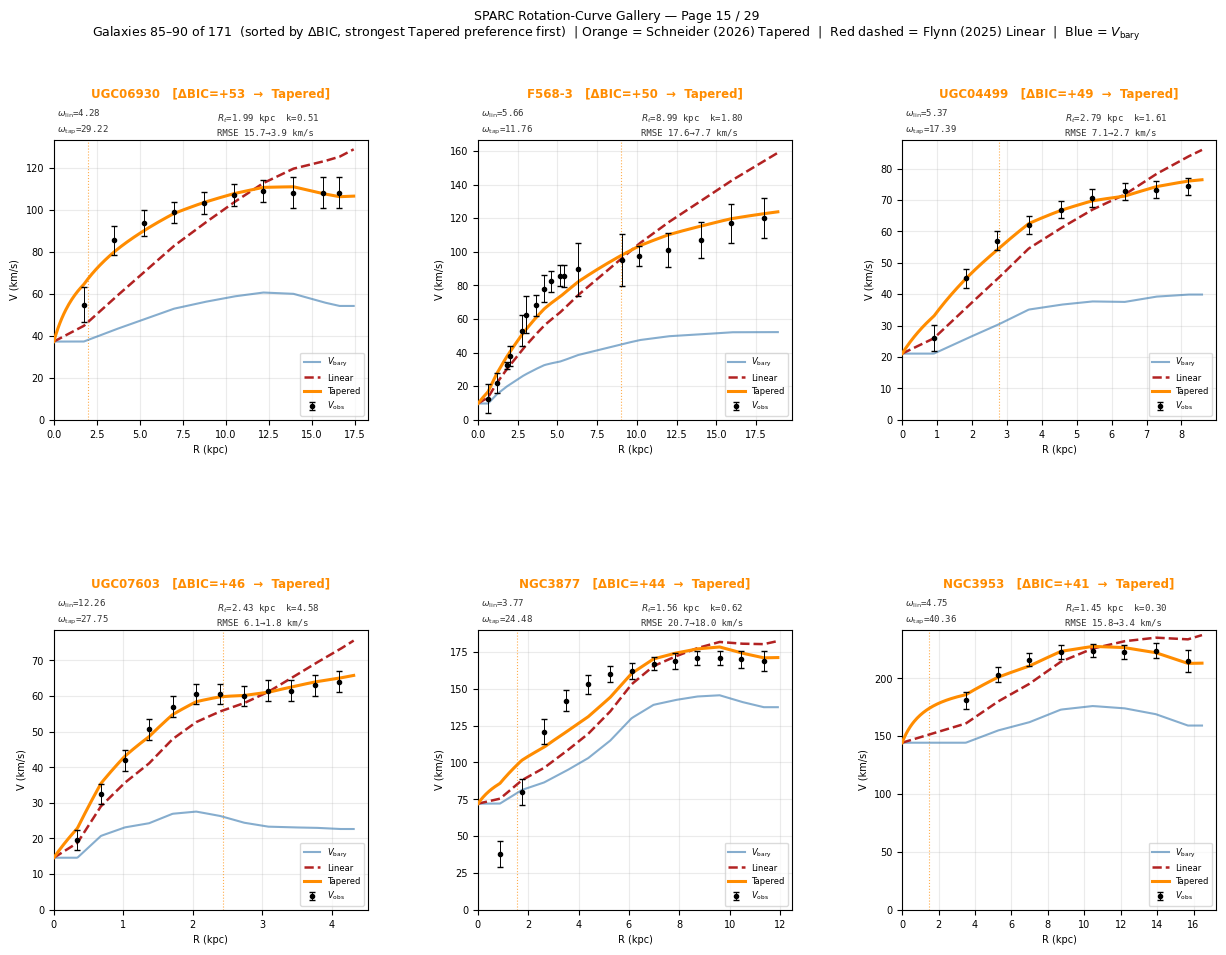

  Saved pages 1–15 ...


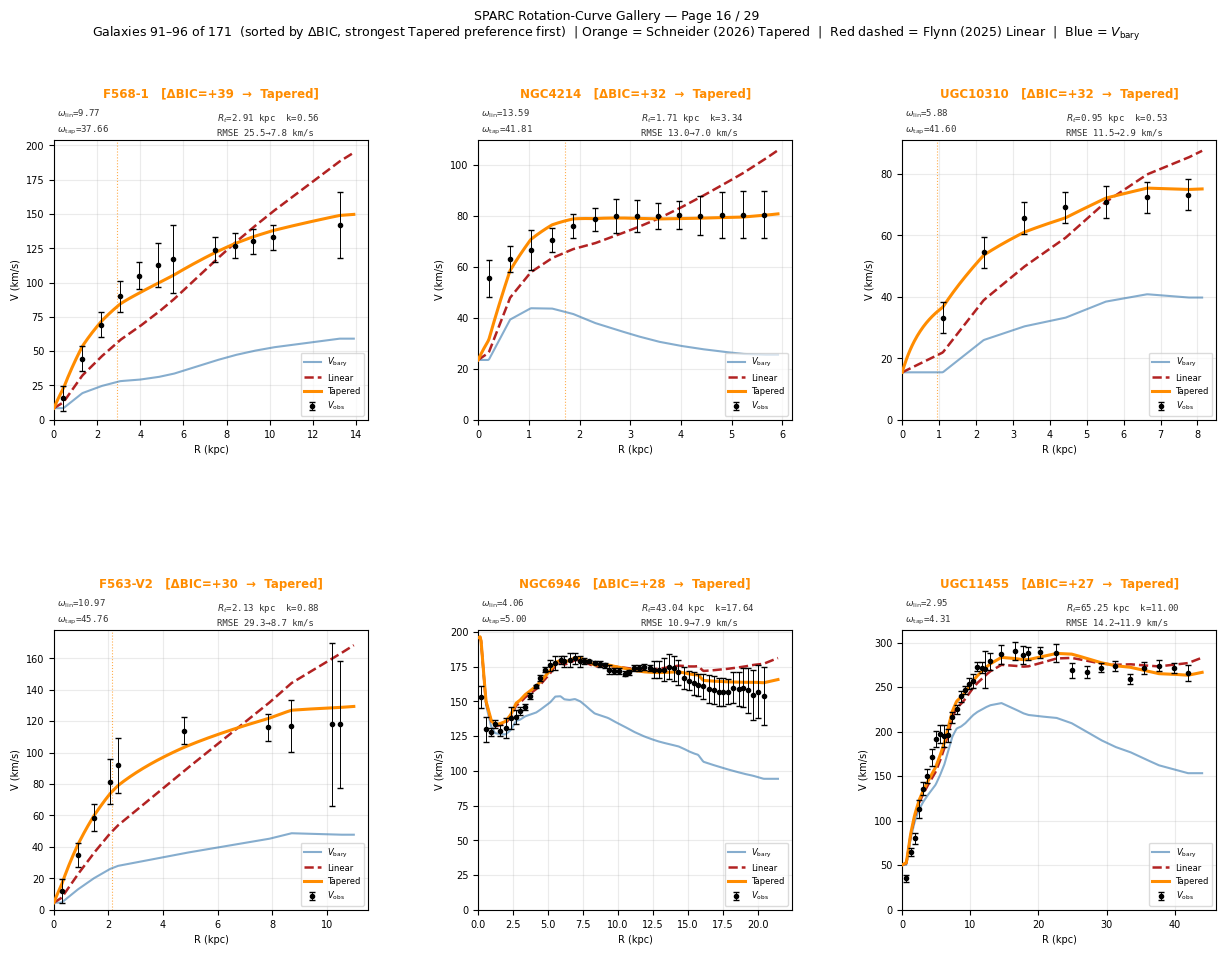

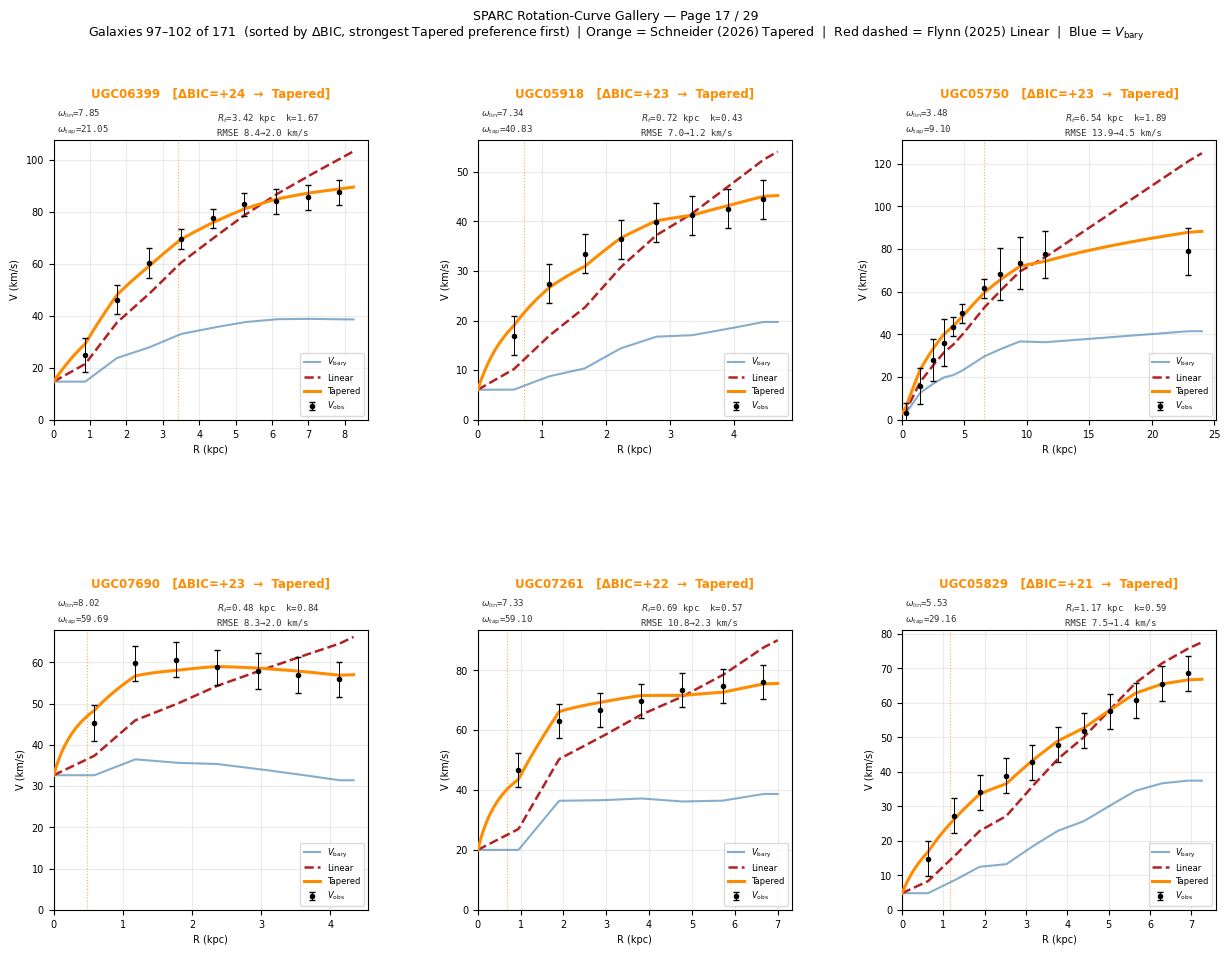

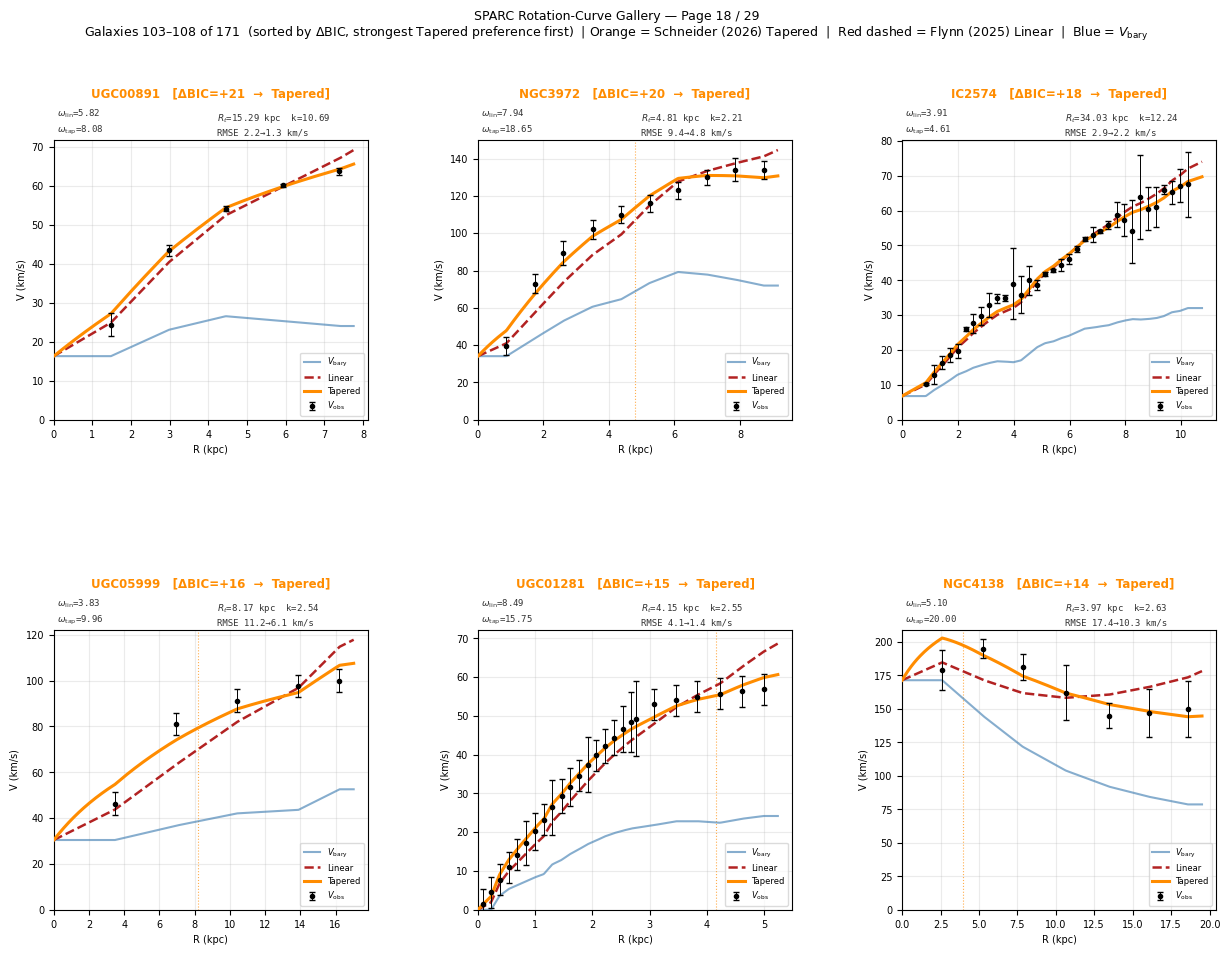

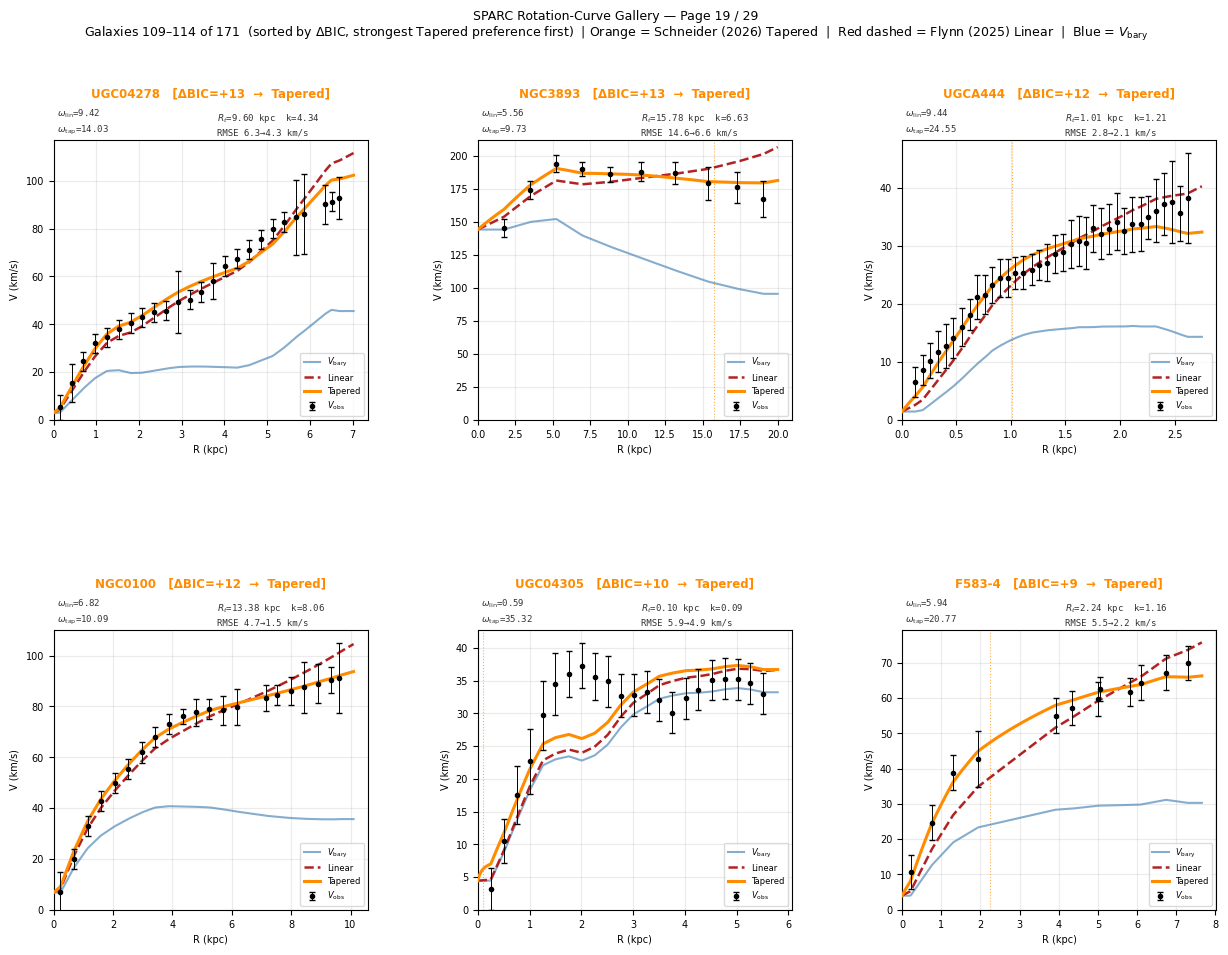

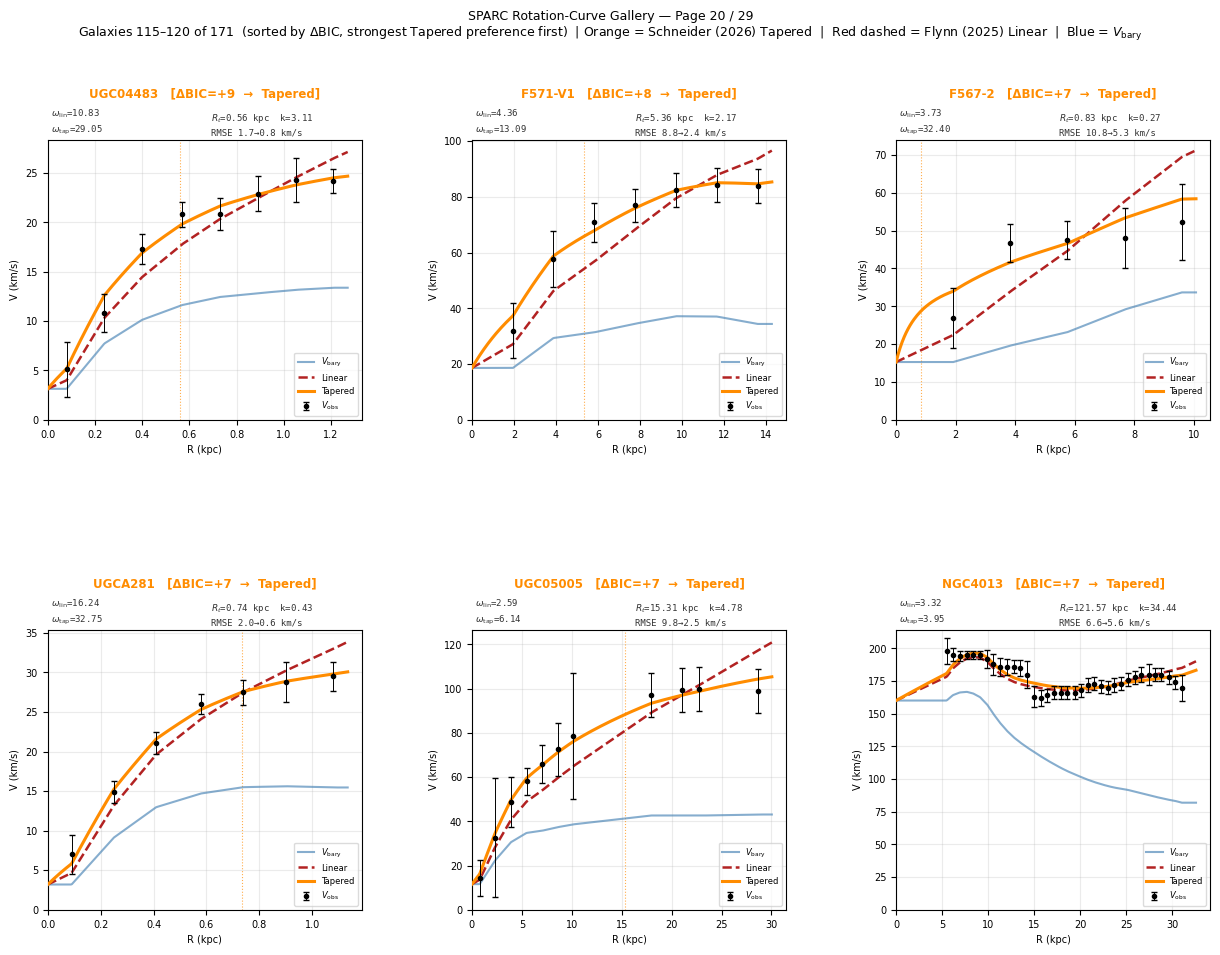

  Saved pages 1–20 ...


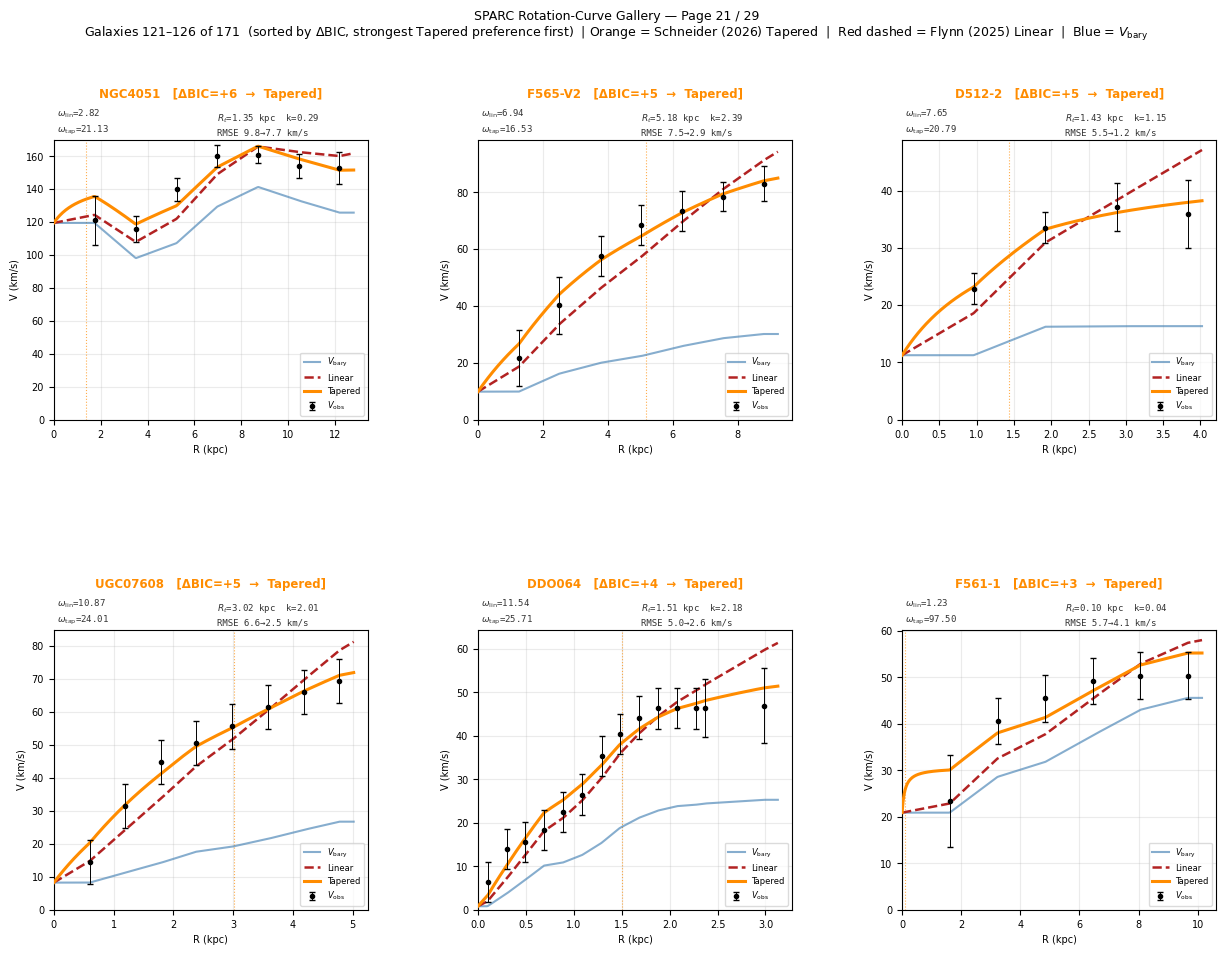

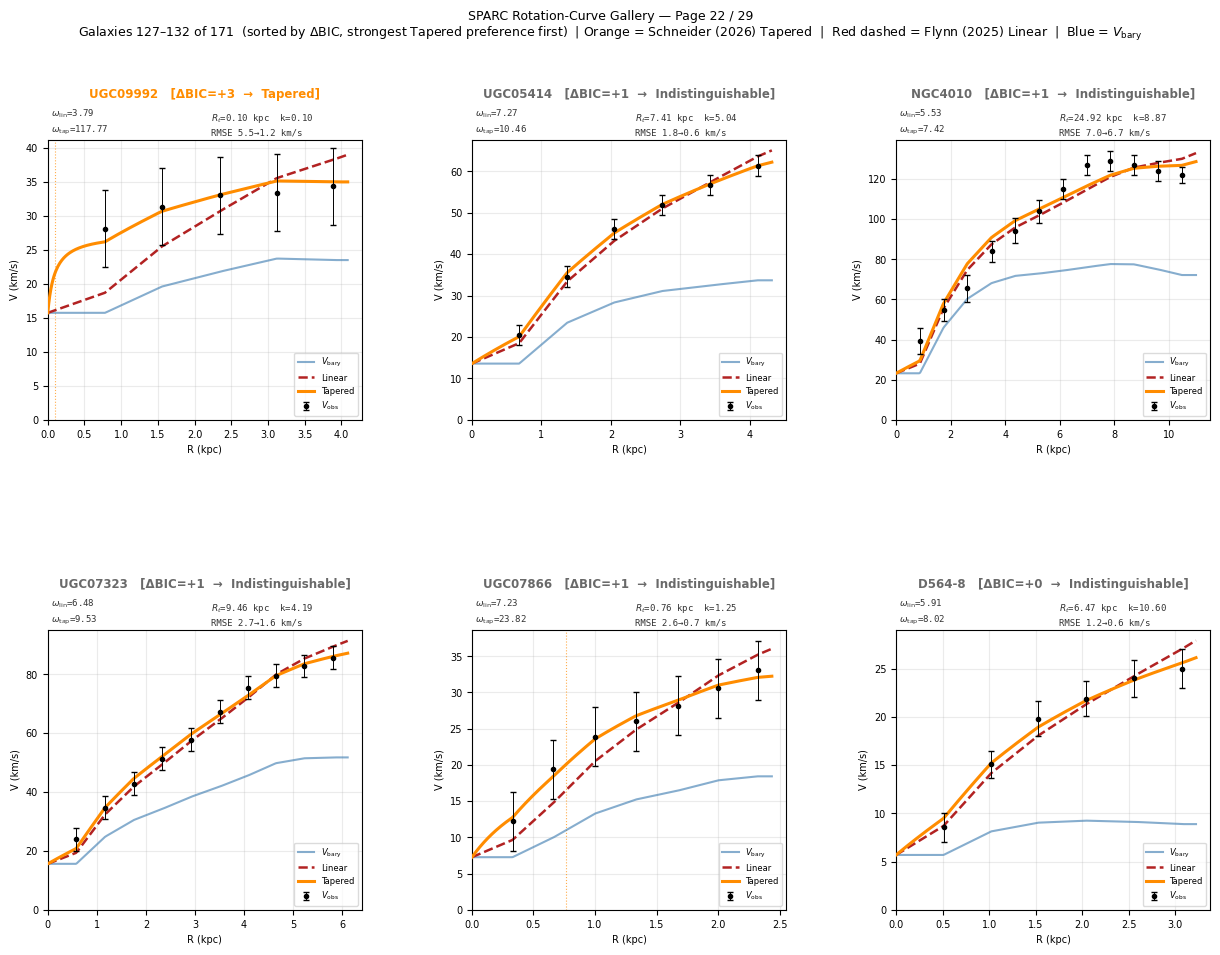

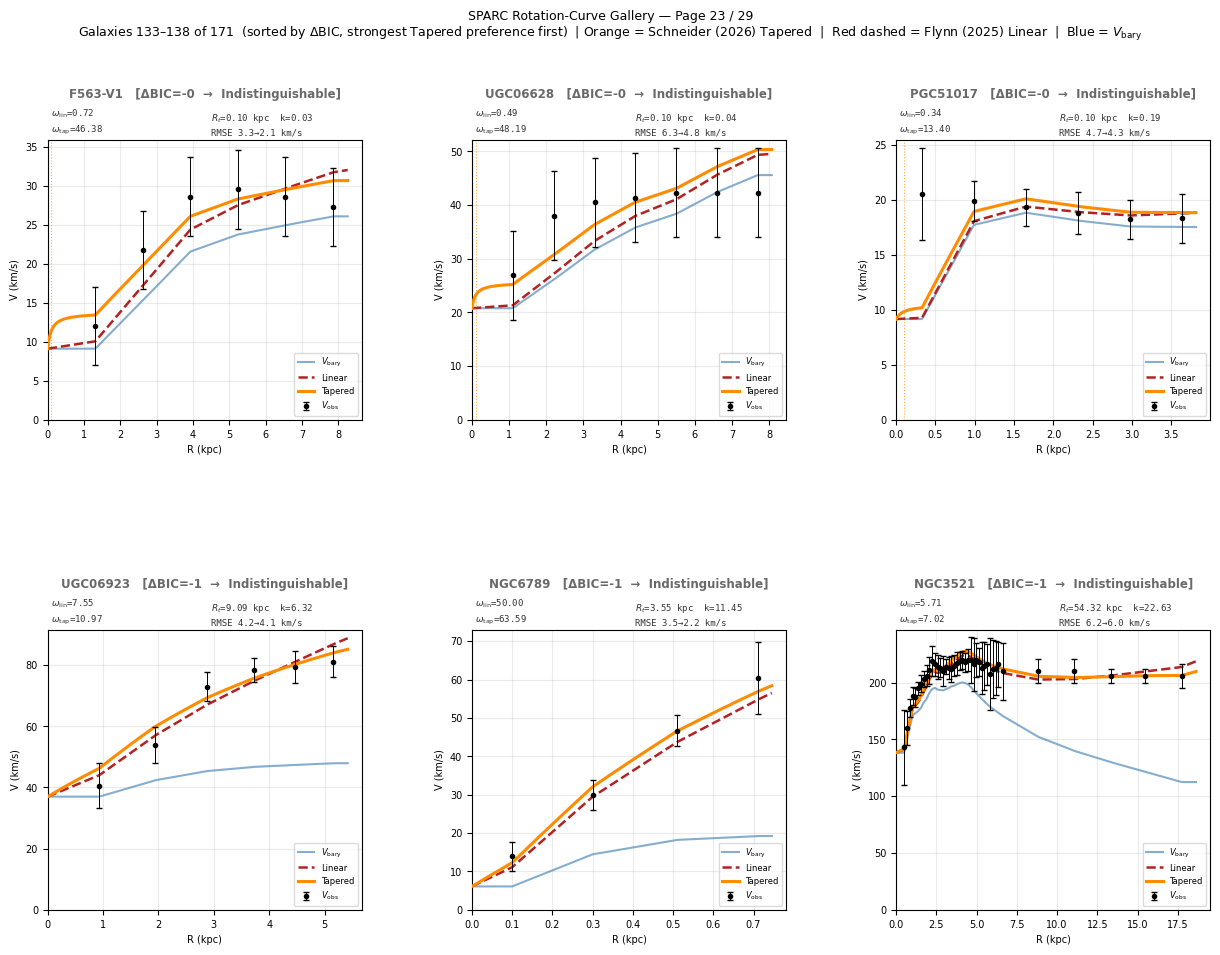

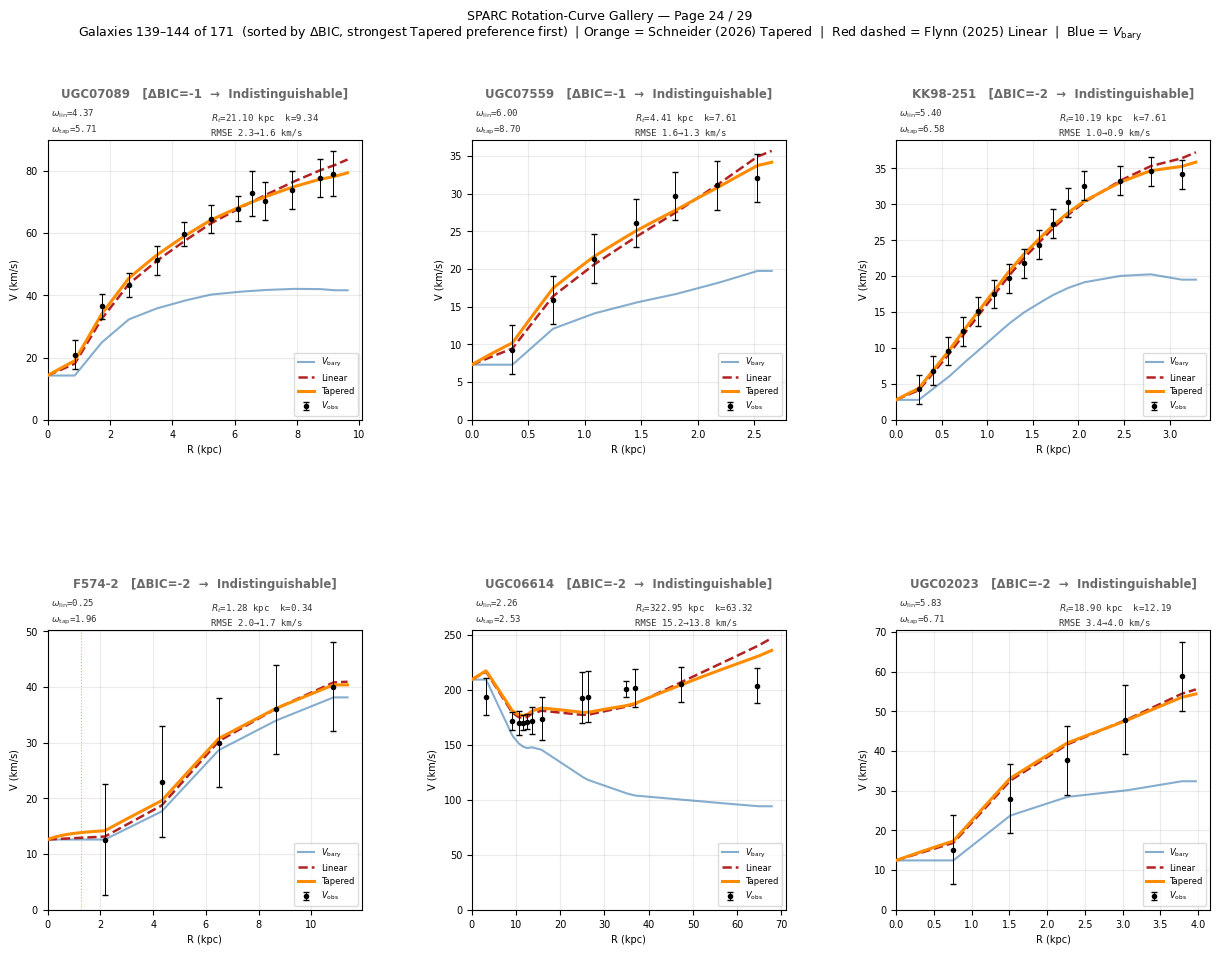

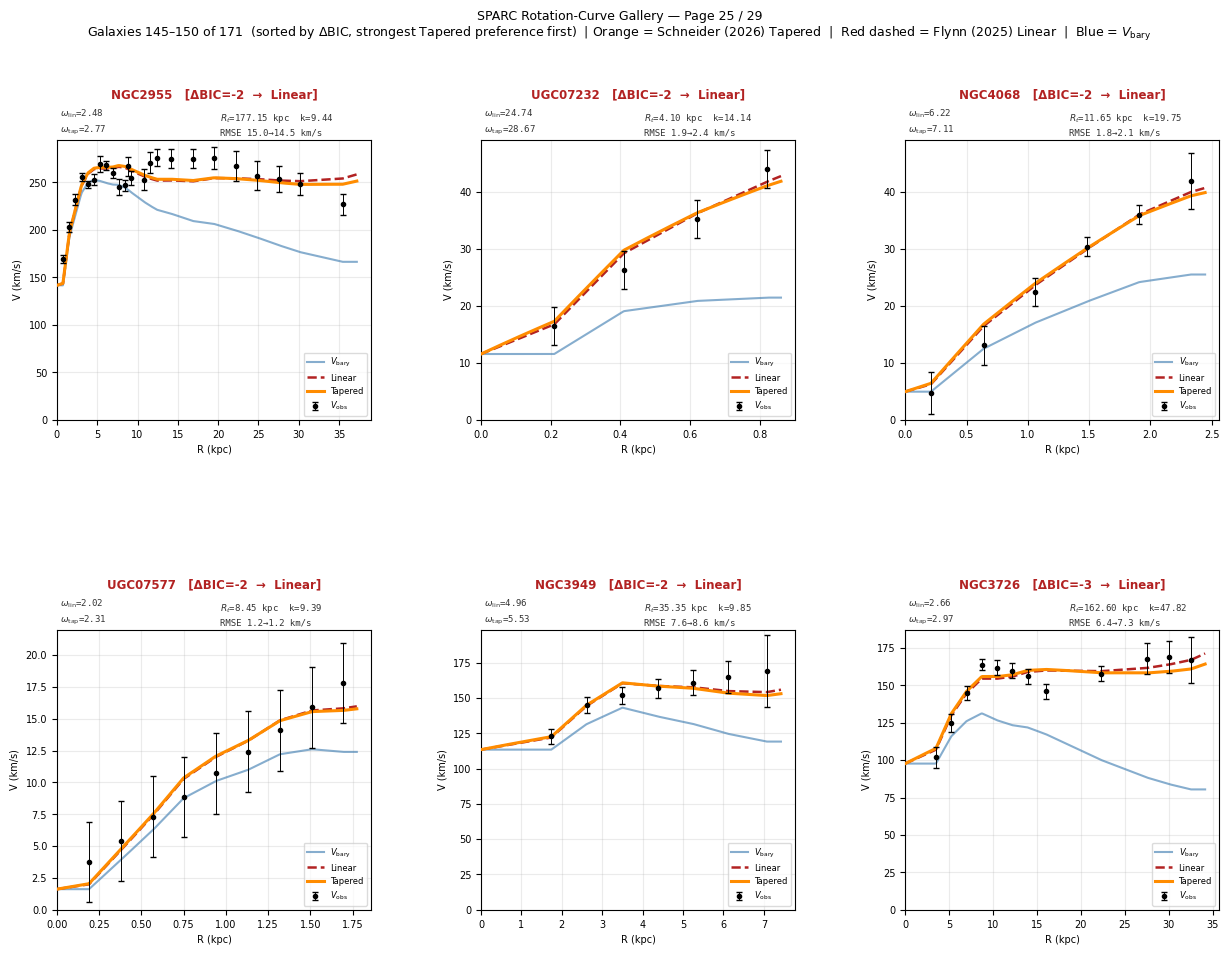

  Saved pages 1–25 ...


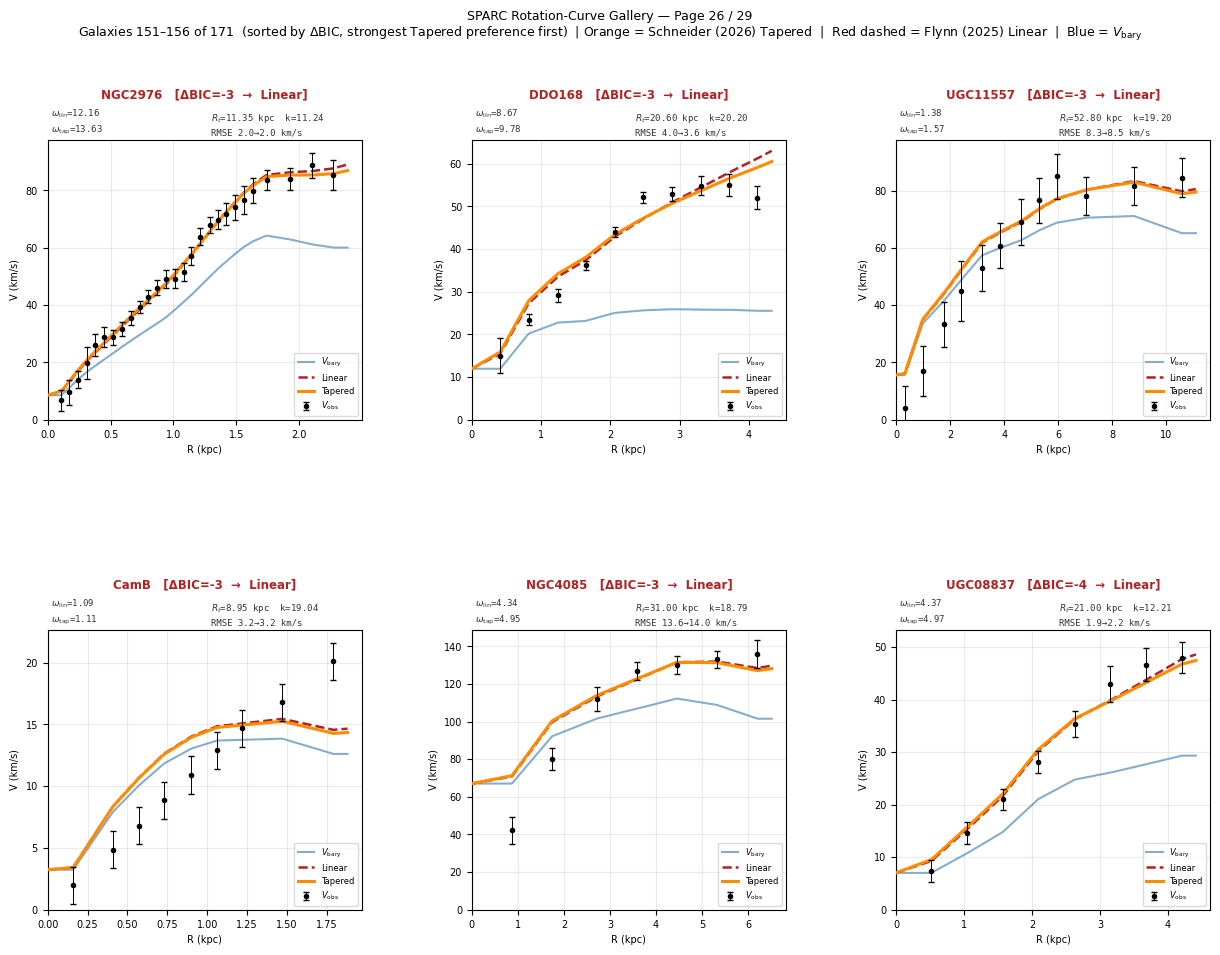

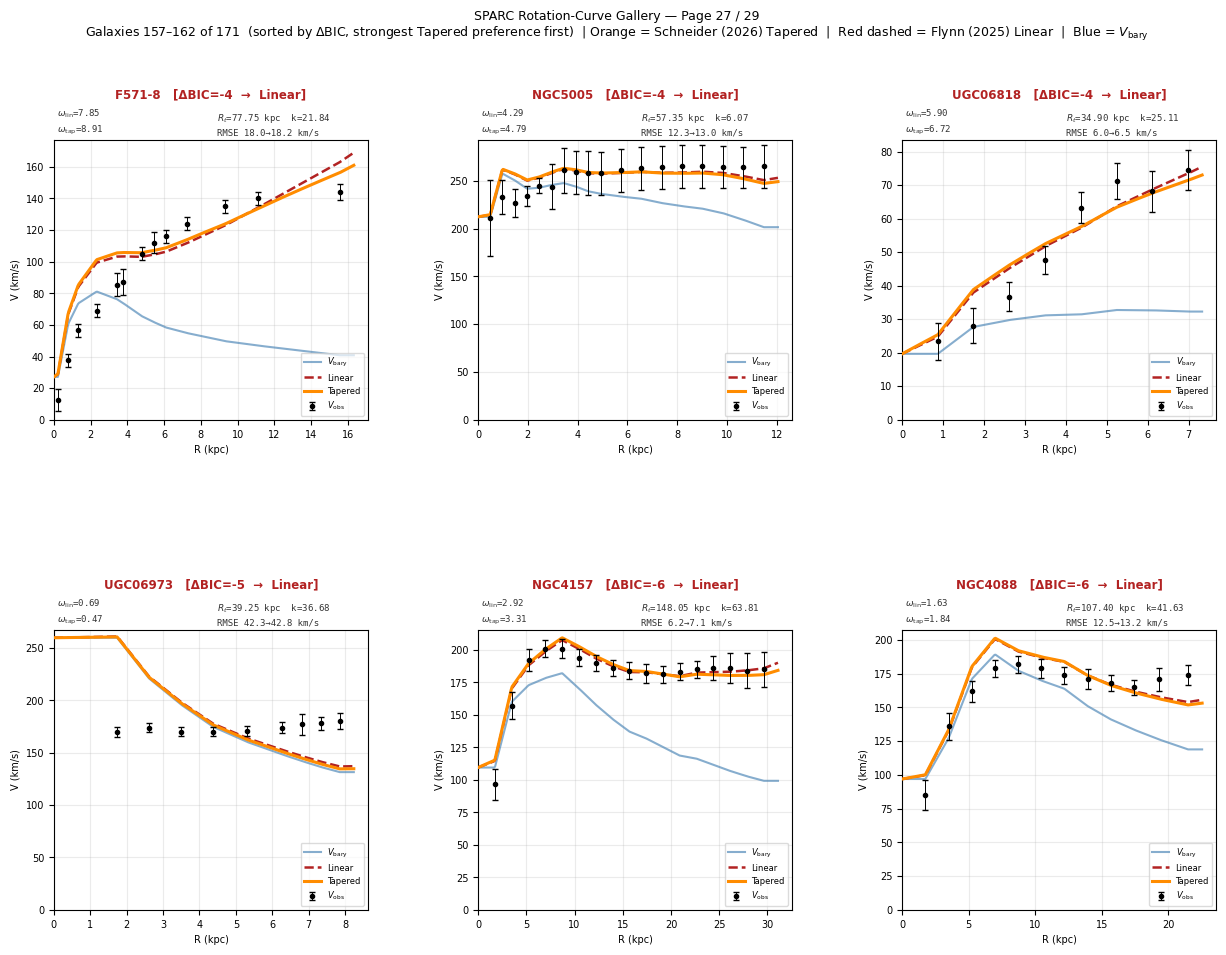

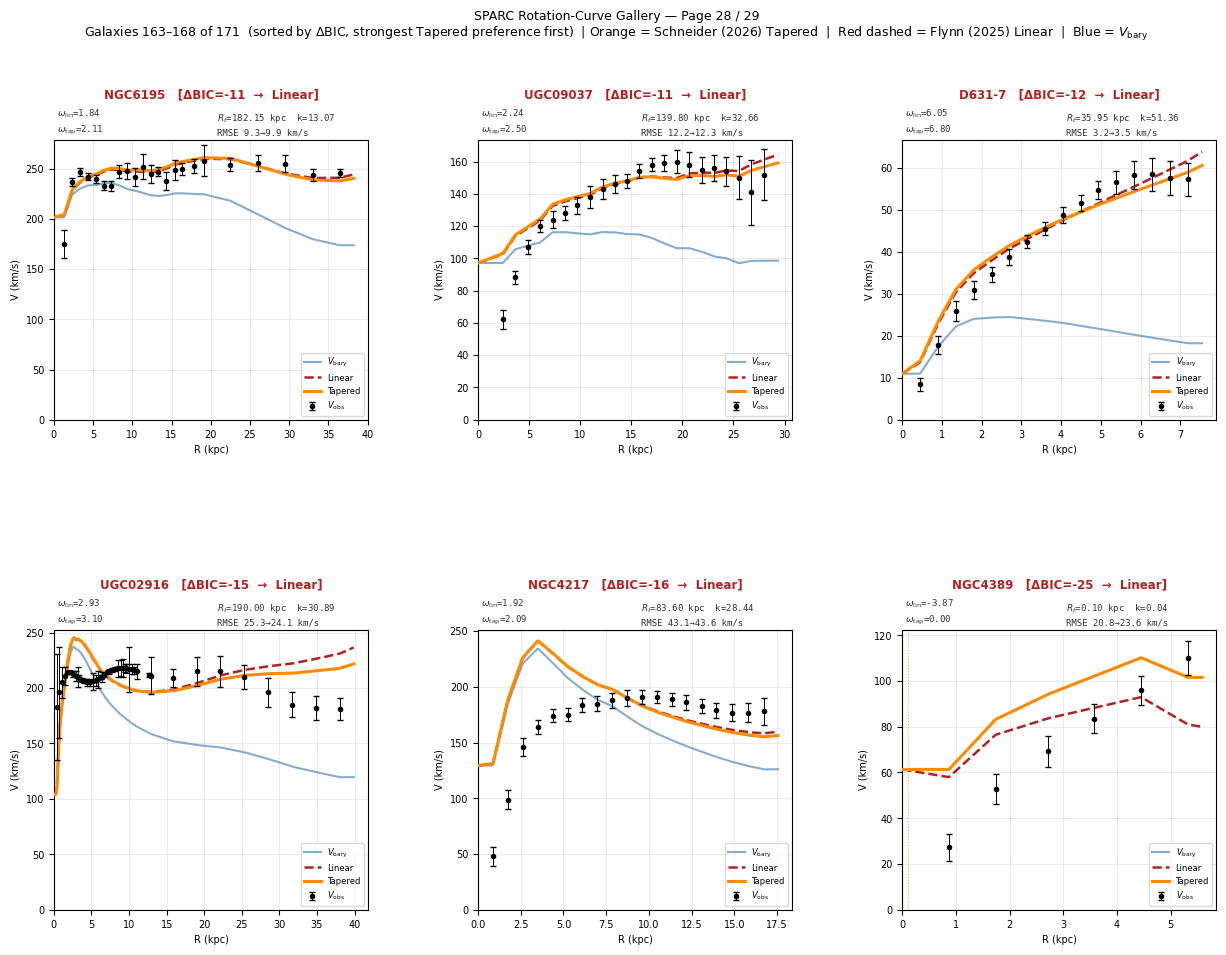

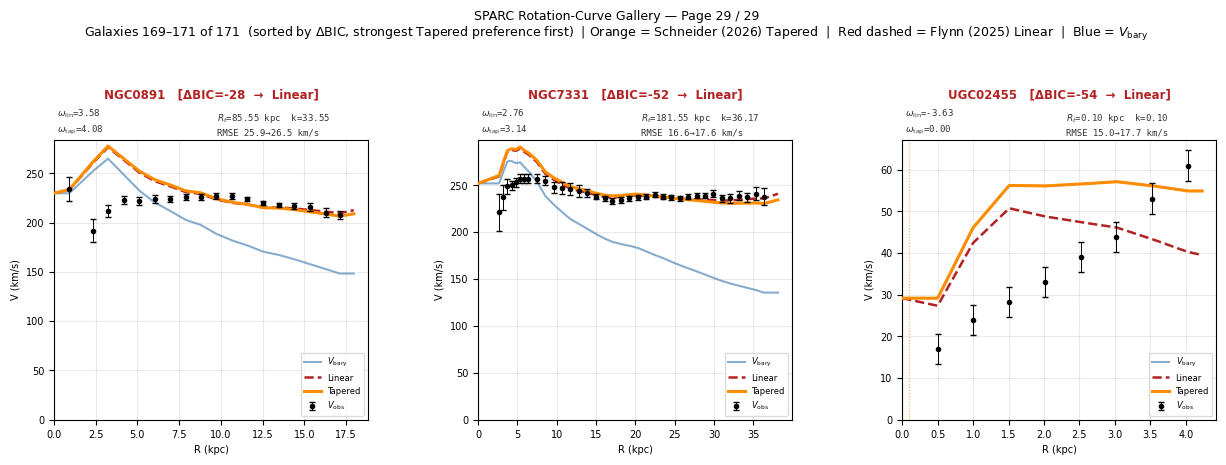


Gallery complete: 29 pages saved to results/figures/


In [19]:
COLS_PER_PAGE = 3
ROWS_PER_PAGE = 2
PANELS_PER_PAGE = COLS_PER_PAGE * ROWS_PER_PAGE

engine  = get_engine()
session = get_session(engine)

n_galaxies  = len(gallery_df)
n_pages     = int(np.ceil(n_galaxies / PANELS_PER_PAGE))
saved_pages = []

print(f'{n_galaxies} galaxies  →  {n_pages} pages of {PANELS_PER_PAGE}')

for page_idx in range(n_pages):

    start = page_idx * PANELS_PER_PAGE
    end   = min(start + PANELS_PER_PAGE, n_galaxies)
    page_rows = gallery_df.iloc[start:end]

    n_panels = len(page_rows)
    fig = plt.figure(figsize=(15, 10))
    gs  = gridspec.GridSpec(
        ROWS_PER_PAGE, COLS_PER_PAGE,
        figure=fig,
        hspace=0.75,   # increased from 0.55 — accommodates title + two-line subtitle
        wspace=0.35,
    )

    for panel_idx, (_, row) in enumerate(page_rows.iterrows()):
        gid = row['GalaxyID']

        try:
            df = query_profiles_as_dataframe(session, gid)
            if df.empty:
                raise ValueError('No data')

            radius  = df['radius_kpc'].values
            v_obs   = df['v_obs'].values
            v_err   = df['v_err'].values
            v_gas   = df['v_gas'].values
            v_disk  = df['v_disk'].values
            v_bulge = df['v_bulge'].values

            v_bary = compute_v_bary(
                v_gas, v_disk, v_bulge,
                upsilon_disk=UPSILON_DISK,
                upsilon_bulge=UPSILON_BULGE,
            )

            r_idx = panel_idx // COLS_PER_PAGE
            c_idx = panel_idx  % COLS_PER_PAGE
            ax = fig.add_subplot(gs[r_idx, c_idx])

            plot_galaxy_panel(
                ax, gid,
                radius, v_obs, v_err, v_bary,
                lin_omega = row['Linear_omega'],
                lin_rmse  = row['Linear_RMSE'],
                lin_bic   = row['Linear_BIC'],
                tap_omega = row['Tapered_omega'],
                tap_rt    = row['Tapered_Rt'],
                tap_rmse  = row['Tapered_RMSE'],
                tap_bic   = row['Tapered_BIC'],
                delta_bic = row['Delta_BIC'],
                preferred = row['Preferred_Model'],
                r_disk    = row['R_disk_kpc'],
            )

        except Exception as exc:
            r_idx = panel_idx // COLS_PER_PAGE
            c_idx = panel_idx  % COLS_PER_PAGE
            ax = fig.add_subplot(gs[r_idx, c_idx])
            ax.text(0.5, 0.5, f'{gid}\n(error: {exc})',
                    ha='center', va='center', transform=ax.transAxes,
                    fontsize=8, color='red')
            ax.set_title(gid, fontsize=8)

    # Hide unused panels on the last page
    for empty_idx in range(n_panels, PANELS_PER_PAGE):
        r_idx = empty_idx // COLS_PER_PAGE
        c_idx = empty_idx  % COLS_PER_PAGE
        ax = fig.add_subplot(gs[r_idx, c_idx])
        ax.set_visible(False)

    fig.suptitle(
        f'SPARC Rotation-Curve Gallery — Page {page_idx + 1} / {n_pages}\n'
        f'Galaxies {start + 1}–{end} of {n_galaxies}  '
        r'(sorted by $\Delta$BIC, strongest Tapered preference first)  '
        r'| Orange = Schneider (2026) Tapered  |  Red dashed = Flynn (2025) Linear  |  Blue = $V_{\rm bary}$',
        fontsize=9, y=1.01,
    )

    out_path = FIGURES_DIR / f'gallery_page_{page_idx + 1:02d}.png'
    fig.savefig(out_path, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    saved_pages.append(out_path)

    if (page_idx + 1) % 5 == 0:
        print(f'  Saved pages 1–{page_idx + 1} ...')

session.close()

print(f'\nGallery complete: {len(saved_pages)} pages saved to results/figures/')

## 5. Summary

In [20]:
print('Gallery Summary')
print('=' * 60)
print(f'Total pages : {len(saved_pages)}')
print(f'Galaxies    : {n_galaxies}')
print()
print('Model preference breakdown (gallery sample):')
for pref, cnt in gallery_df['Preferred_Model'].value_counts().items():
    print(f'  {pref:22s}: {cnt:3d} ({cnt/n_galaxies*100:.1f}%)')
print()
print('Top 10 strongest Tapered wins:')
display(
    gallery_df[['GalaxyID','Delta_BIC','Linear_RMSE','Tapered_RMSE','Tapered_Rt']]
    .head(10)
    .to_string(index=False)
)
print()
print('Top 5 galaxies where Linear is preferred:')
lin_pref = gallery_df[gallery_df['Preferred_Model'] == 'Linear']
display(
    lin_pref[['GalaxyID','Delta_BIC','Linear_RMSE','Tapered_RMSE']]
    .head(5)
    .to_string(index=False)
)
print()
print('Output files:')
for p in saved_pages[:5]:
    print(f'  {p.name}')
if len(saved_pages) > 5:
    print(f'  ... ({len(saved_pages) - 5} more)')

Gallery Summary
Total pages : 29
Galaxies    : 171

Model preference breakdown (gallery sample):
  Tapered               : 127 (74.3%)
  Linear                :  27 (15.8%)
  Indistinguishable     :  17 (9.9%)

Top 10 strongest Tapered wins:


'GalaxyID    Delta_BIC  Linear_RMSE  Tapered_RMSE  Tapered_Rt\nUGC02953 19023.775462    41.706512     21.902089   13.019013\n NGC2403 16435.169649    18.574836      5.425678    4.892791\nUGC00128 12763.397137    35.111712      6.376166    1.771337\nUGC09133  8395.353240    32.673018     17.658819   22.775297\nUGC06787  5474.696377    23.456351     18.651687   16.963879\n NGC6015  4779.117337    26.250964     11.038340    2.169061\n NGC3198  4689.301410    22.335921      6.442369    8.664450\nUGC05716  3517.706160    15.026353      1.431934    1.363771\nUGC06786  2470.848150    30.192889     10.449394   11.424917\nUGC05253  2305.826176    26.166708     16.537384   27.395005'


Top 5 galaxies where Linear is preferred:


'GalaxyID  Delta_BIC  Linear_RMSE  Tapered_RMSE\n NGC2955  -2.070849    14.999058     14.518560\nUGC07232  -2.124343     1.948980      2.409951\n NGC4068  -2.259582     1.769189      2.058913\nUGC07577  -2.282171     1.185665      1.225009\n NGC3949  -2.465864     7.607328      8.639744'


Output files:
  gallery_page_01.png
  gallery_page_02.png
  gallery_page_03.png
  gallery_page_04.png
  gallery_page_05.png
  ... (24 more)


In [21]:
log = setup_logger('nb08_full_gallery', log_file=True, clear_logs=True)

log.info('=' * 65)
log.info('NOTEBOOK 08 -- FULL ROTATION-CURVE GALLERY')
log.info('=' * 65)
log.info('Upsilon_disk=%.2f, Upsilon_bulge=%.2f', UPSILON_DISK, UPSILON_BULGE)
log.info('Panels per page: %d (%d rows x %d cols)',
         PANELS_PER_PAGE, ROWS_PER_PAGE, COLS_PER_PAGE)
log.info('Galaxies: %d  |  Pages: %d', n_galaxies, len(saved_pages))
log.info('Sort order: descending Delta_BIC (strongest Tapered first)')
log.info('---')
for pref, cnt in gallery_df['Preferred_Model'].value_counts().items():
    log.info('  %-22s: %d (%.1f%%)', pref, cnt, cnt/n_galaxies*100)
log.info('---')
log.info('Output: results/figures/gallery_page_NN.png  (%d files)', len(saved_pages))
log.info('=' * 65)

print('Log written to logs/nb08_full_gallery.log')

2026-02-18 15:01:15 | INFO     | nb08_full_gallery | =================================================================
2026-02-18 15:01:15 | INFO     | nb08_full_gallery | NOTEBOOK 08 -- FULL ROTATION-CURVE GALLERY
2026-02-18 15:01:15 | INFO     | nb08_full_gallery | =================================================================
2026-02-18 15:01:15 | INFO     | nb08_full_gallery | Upsilon_disk=0.50, Upsilon_bulge=0.70
2026-02-18 15:01:15 | INFO     | nb08_full_gallery | Panels per page: 6 (2 rows x 3 cols)
2026-02-18 15:01:15 | INFO     | nb08_full_gallery | Galaxies: 171  |  Pages: 29
2026-02-18 15:01:15 | INFO     | nb08_full_gallery | Sort order: descending Delta_BIC (strongest Tapered first)
2026-02-18 15:01:15 | INFO     | nb08_full_gallery | ---
2026-02-18 15:01:15 | INFO     | nb08_full_gallery |   Tapered               : 127 (74.3%)
2026-02-18 15:01:15 | INFO     | nb08_full_gallery |   Linear                : 27 (15.8%)
2026-02-18 15:01:15 | INFO     | nb08_full_gallery |  

Log written to logs/nb08_full_gallery.log
